In [ ]:
def update_progress(n,max_value):
    ''' Create a progress bar
    
    Args:
        n (int): current count
        max_value (int): ultimate values
    
    '''
    import sys
    barLength = 20 # Modify this to change the length of the progress bar
    status = ""
    progress = np.round(float(n/max_value),decimals=2)
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    #if progress >= 1.:
    #    progress = 1
    #    status = "Done...\r\n"
    if n == max_value:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\r{0}% ({1} of {2}): |{3}|  {4}".format(np.round(progress*100,decimals=1), 
                                                  n, 
                                                  max_value, 
                                                  "#"*block + "-"*(barLength-block), 
                                                  status)
    sys.stdout.write(text)
    sys.stdout.flush()

def MonteCarloIt(thing, N = 10000):
    ''' 
    Generate a random sample of size = N from a 
    Gaussian centered at thing[0] with std thing[1]
    
    Args:
        thing (tuple, flt): tuple of (value,uncertainty).  Can be either astropy units object \
            or float
        N (int): number of samples
    Returns:
        array: N random samples from a Gaussian.

    Written by Logan Pearce, 2020
    '''
    try:
        out = np.random.normal(thing[0].value,thing[1].value,N)
    except:
        out = np.random.normal(thing[0],thing[1],N)

    return out

In [22]:
directory = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/'

file = 'MIST_v1.2_feh_m0.25_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd'
mist = pd.read_table(directory+file, delim_whitespace = True, comment = "#",
                    names = ['EEP','log10_isochrone_age_yr','initial_mass','star_mass','log_Teff',\
                             'log_g','log_L','[Fe/H]_init','[Fe/H]','SDSS_u','SDSS_g','SDSS_r',\
                             'SDSS_i','SDSS_z','phase'])
mist['g-r'] = mist['SDSS_g'] - mist['SDSS_r']
mist['r-i'] = mist['SDSS_r'] - mist['SDSS_i']
mist


EEP  log10_isochrone_age_yr  initial_mass  star_mass  log_Teff  \
0         14                     5.0      0.100000   0.100000  3.486221   
1         15                     5.0      0.102645   0.102645  3.487362   
2         16                     5.0      0.107039   0.107039  3.489243   
3         17                     5.0      0.111419   0.111419  3.491102   
4         18                     5.0      0.115789   0.115789  3.492937   
...      ...                     ...           ...        ...       ...   
104418  1706                    10.3      0.806514   0.528542  4.383771   
104419  1707                    10.3      0.806542   0.528544  4.376795   
104420  1708                    10.3      0.806574   0.528547  4.369815   
104421  1709                    10.3      0.806609   0.528550  4.362831   
104422  1710                    10.3      0.806648   0.528554  4.355845   

           log_g     log_L  [Fe/H]_init    [Fe/H]     SDSS_u     SDSS_g  \
0       3.131342 -0.793667        -0.25 -0.217200  12.560034  10.519608   
1       3.126808 -0.775254        -0.25 -0.217200  12.499993  10.451853   
2       3.119367 -0.744810        -0.25 -0.217200  12.401449  10.339976   
3       3.112165 -0.714749        -0.25 -0.217200  12.304754  10.229589   
4       3.105143 -0.684996        -0.25 -0.217200  12.209562  10.120605   
...          ...       ...          ...       ...        ...        ...   
104418  7.775384 -1.124458        -0.25 -0.231012   9.715343   9.850622   
104419  7.778159 -1.155137        -0.25 -0.231008   9.766171   9.889662   
104420  7.780884 -1.185780        -0.25 -0.231000   9.816455   9.928136   
104421  7.783561 -1.216388        -0.25 -0.230994   9.866285   9.966114   
104422  7.786189 -1.246960        -0.25 -0.230987   9.915736  10.003642   

           SDSS_r     SDSS_i     SDSS_z  phase       g-r       r-i  
0        9.309737   7.454909   6.501355   -1.0  1.209871  1.854828  
1        9.242194   7.400784   6.452352   -1.0  1.209659  1.841410  
2        9.130598   7.311358   6.371431   -1.0  1.209378  1.819240  
3        9.020346   7.223101   6.291711   -1.0  1.209243  1.797245  
4        8.911321   7.135880   6.213110   -1.0  1.209284  1.775441  
...           ...        ...        ...    ...       ...       ...  
104418  10.273517  10.609936  10.940374    6.0 -0.422895 -0.336419  
104419  10.308484  10.642954  10.972020    6.0 -0.418822 -0.334470  
104420  10.342867  10.675371  11.003057    6.0 -0.414731 -0.332504  
104421  10.376733  10.707260  11.033557    6.0 -0.410619 -0.330527  
104422  10.410129  10.738666  11.063568    6.0 -0.406487 -0.328537  

[104423 rows x 17 columns]

### Load photometry in SDSS magnitudes from (2):

In [23]:
Amag_SDSS,e_Amag_SDSS,Cmag_SDSS,e_Cmag_SDSS = pickle.load(open('SDSS-magnitudes-noatm.pkl','rb'))

Cmag_SDSS_dict = {'z':Cmag_SDSS[0],'i':Cmag_SDSS[1],'r':Cmag_SDSS[2],'g':Cmag_SDSS[3]}
e_Cmag_SDSS_dict = {'z':e_Cmag_SDSS[0],'i':e_Cmag_SDSS[1],'r':e_Cmag_SDSS[2],'g':e_Cmag_SDSS[3]}

Amag_SDSS_dict = {'z':Amag_SDSS[0],'i':Amag_SDSS[1],'r':Amag_SDSS[2],'g':Amag_SDSS[3]}
e_Amag_SDSS_dict = {'z':e_Amag_SDSS[0],'i':e_Amag_SDSS[1],'r':e_Amag_SDSS[2],'g':e_Amag_SDSS[3]}

# Monte Carlo for uncert:
CRminusI = MonteCarloIt([Cmag_SDSS_dict['r'],e_Cmag_SDSS_dict['r']]) - \
            MonteCarloIt([Cmag_SDSS_dict['i'],e_Cmag_SDSS_dict['i']])
CGminusR = MonteCarloIt([Cmag_SDSS_dict['g'],e_Cmag_SDSS_dict['g']]) - \
            MonteCarloIt([Cmag_SDSS_dict['r'],e_Cmag_SDSS_dict['r']])

ARminusI = MonteCarloIt([Amag_SDSS_dict['r'],e_Amag_SDSS_dict['r']]) - \
            MonteCarloIt([Amag_SDSS_dict['i'],e_Amag_SDSS_dict['i']])
AGminusR = MonteCarloIt([Amag_SDSS_dict['g'],e_Amag_SDSS_dict['g']]) - \
            MonteCarloIt([Amag_SDSS_dict['r'],e_Amag_SDSS_dict['r']])

Adistance = [220,2]

C_Mr = MonteCarloIt([Cmag_SDSS_dict['r'],e_Cmag_SDSS_dict['r']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
A_Mr = MonteCarloIt([Amag_SDSS_dict['r'],e_Amag_SDSS_dict['r']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
C_Mg = MonteCarloIt([Cmag_SDSS_dict['g'],e_Cmag_SDSS_dict['g']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
A_Mg = MonteCarloIt([Amag_SDSS_dict['g'],e_Amag_SDSS_dict['g']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
C_Mi = MonteCarloIt([Cmag_SDSS_dict['i'],e_Cmag_SDSS_dict['i']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
A_Mi = MonteCarloIt([Amag_SDSS_dict['i'],e_Amag_SDSS_dict['i']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
C_Mz = MonteCarloIt([Cmag_SDSS_dict['z'],e_Cmag_SDSS_dict['z']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
A_Mz = MonteCarloIt([Amag_SDSS_dict['z'],e_Amag_SDSS_dict['z']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5

In [24]:
mist['chi2'] = np.nan

# Make vector of data:

CM = [np.mean(C_Mg),np.mean(C_Mr),np.mean(C_Mi),np.mean(C_Mz)]
eCM = [np.std(C_Mg),np.std(C_Mr),np.std(C_Mi),np.std(C_Mz)]
CMIST = ['SDSS_g','SDSS_r','SDSS_i','SDSS_z']

colorlist = [np.mean(CRminusI),np.mean(CGminusR)]
ecolorlist = [np.std(CRminusI),np.std(CGminusR)]
colormist = ['r-i','g-r']

import warnings
warnings.filterwarnings('ignore')
# for each model:
for i in range(len(mist)):
    # compute chi2 from filter magnitudes:
    chisq = np.sum([( (CM[j]-mist[CMIST[j]][i]) / eCM[j] )**2 for j in range(4)])
    # add chi2 from colors:
    chisq += np.sum( [( (colorlist[j]-mist[colormist[j]][i]) / ecolorlist[j] )**2 for j in range(2)] )
    # store in dataframe:
    mist['chi2'][i] = chisq
    update_progress(i,len(mist))
    

100.0% (104422 of 104423): |####################|  

In [25]:
mist.to_csv(file+'--chi2-output-C.csv', index=False)

In [7]:
# sort on chi2:
ind = np.argsort(mist['chi2'])
ind[0],np.where(mist['chi2'] == np.min(mist['chi2']))
for i in range(4):
    print(CM[i],mist[CMIST[i]][ind[0]])
print(mist['chi2'][ind[0]])

9.990027178653364 10.268125
8.902103964472499 8.840256
7.7370361320205205 7.851191
7.333961544421475 7.253416
32.579081049147206


<IPython.core.display.Javascript object>


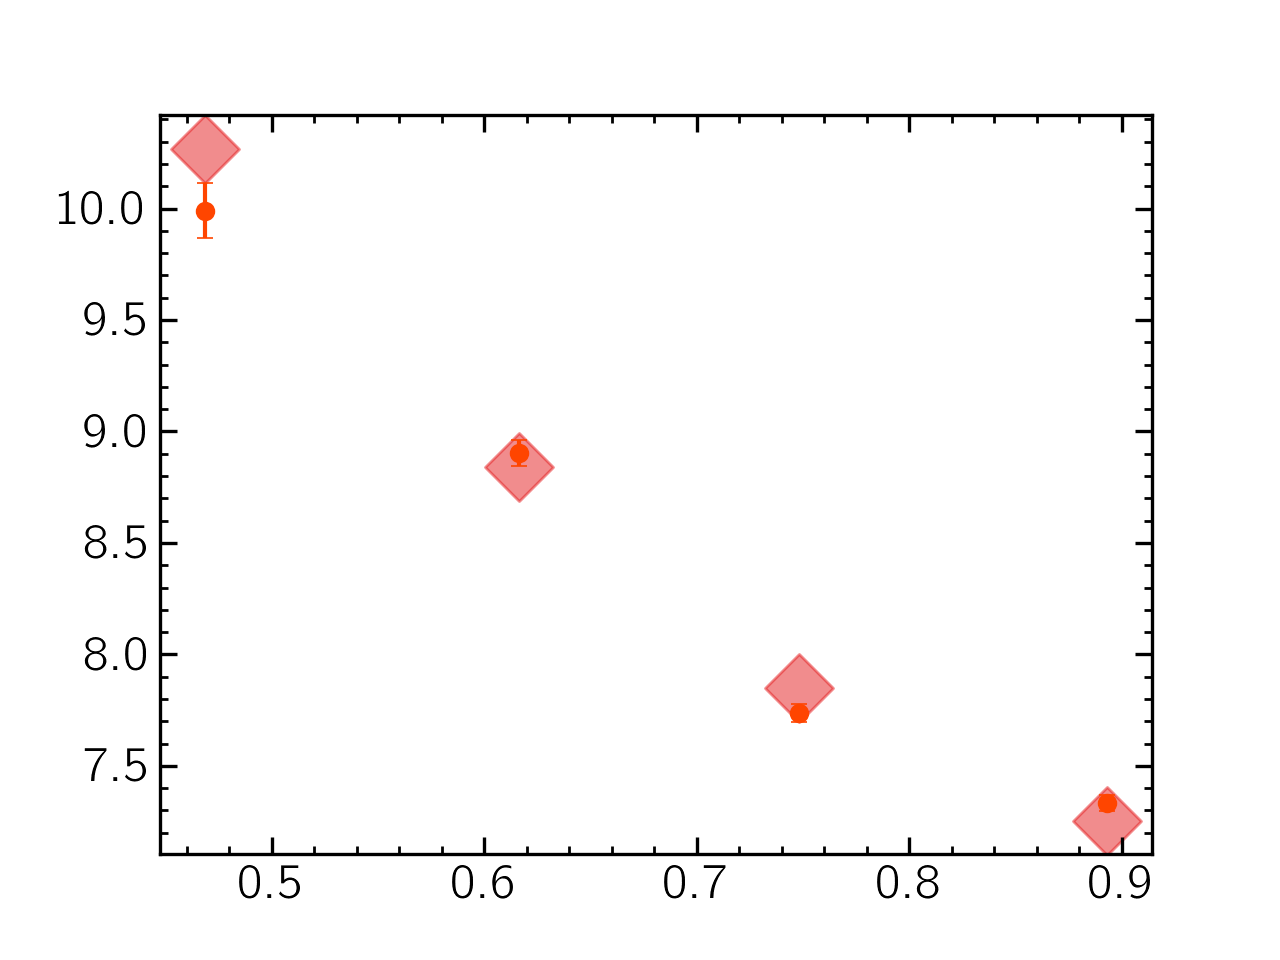

In [11]:
Cmist = mist
SDSS_filters = {'z':0.8931,'i':0.7481,'r':0.6165,'g':.4686}
f = [SDSS_filters['g'],SDSS_filters['r'],SDSS_filters['i'],SDSS_filters['z']]

j=0
for i in range(4):
    plt.scatter(f[i],Cmist[AMIST[i]].loc[ind[j]], color=colors[j], marker='D', s=300, alpha = 0.5)

color = 'orangered'
for i in range(4):
    plt.scatter(f[i],CM[i], zorder=10, color=color)
    plt.errorbar(f[i],CM[i],yerr = eCM[i], ls='None', capsize = 3, 
                 zorder=10, color=color)

<IPython.core.display.Javascript object>


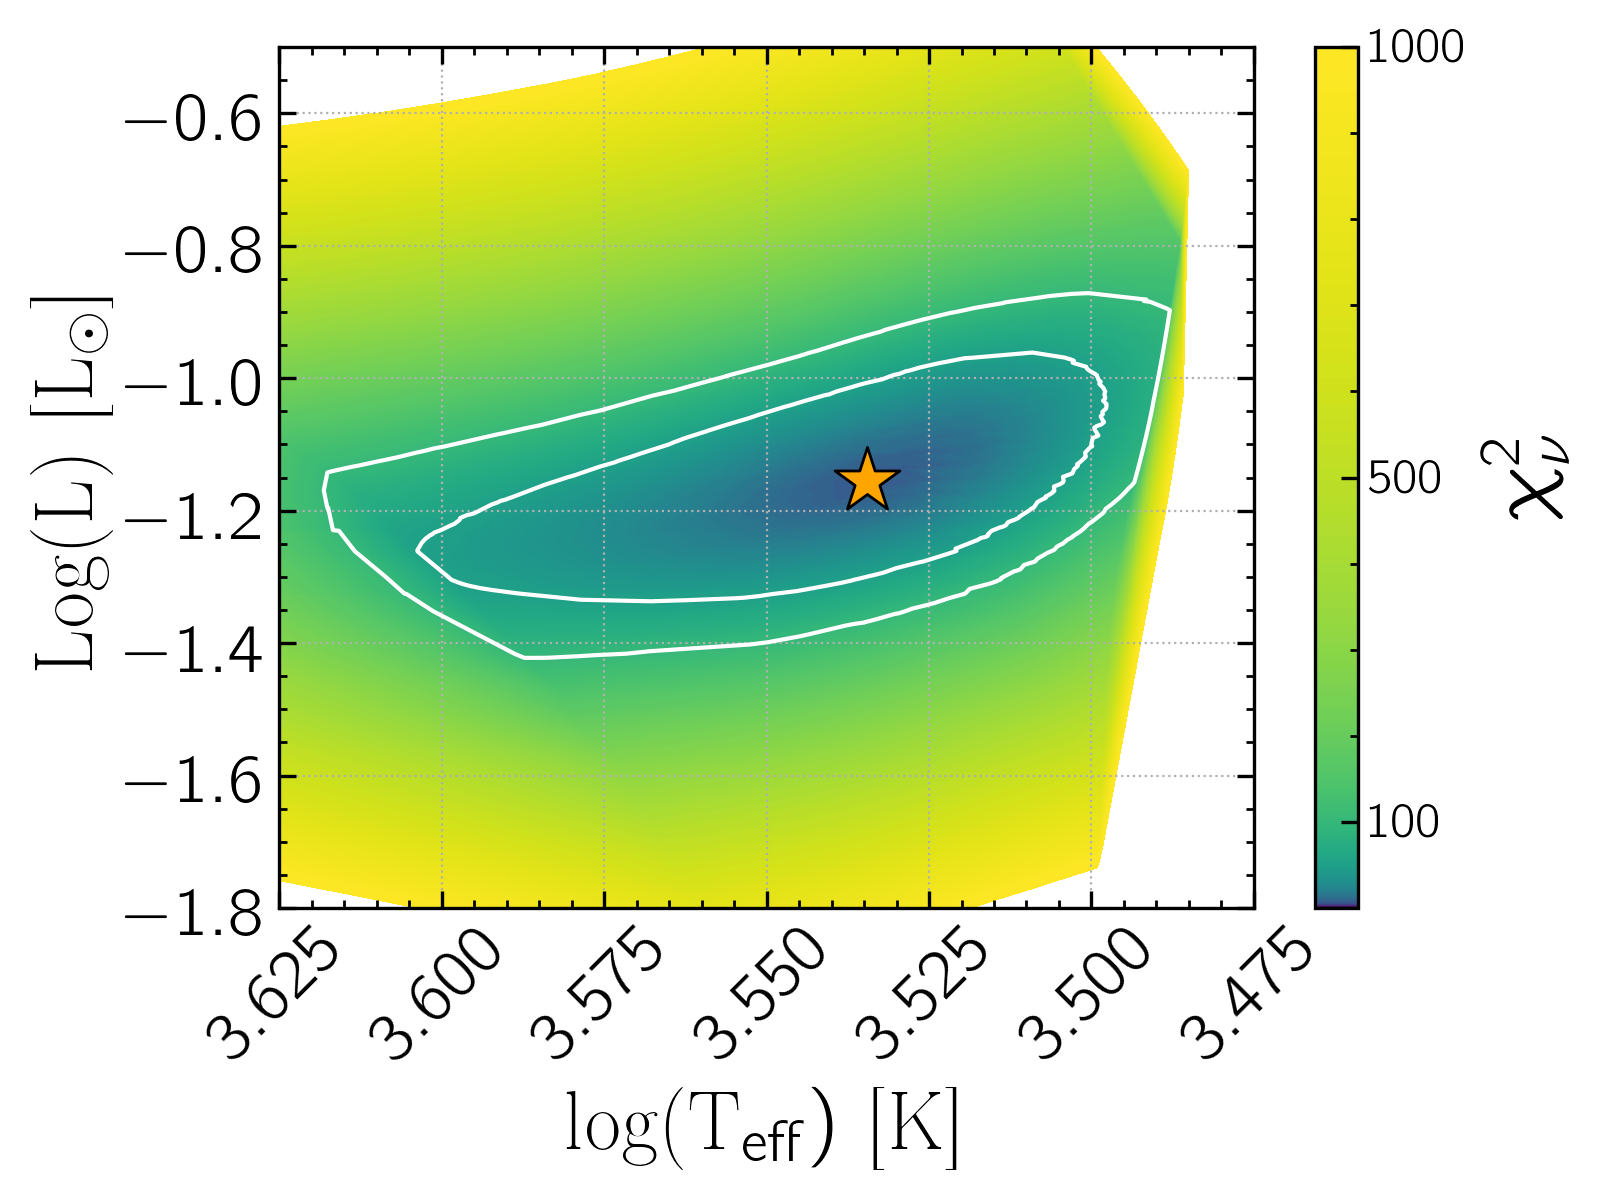

In [61]:
# Plot Teff vs Lum and lowest chi2:

import matplotlib
from matplotlib.ticker import LogLocator, LogFormatter
l_f = LogFormatter(10)


plt.style.use('magrathea')
%matplotlib inline
plt.grid(ls=':')
levels = np.linspace(0,1000,1000)
im = plt.tricontourf(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, cmap = 'viridis', 
                norm=matplotlib.colors.LogNorm())
cbarticks = [100,500,1000]
cbar = plt.colorbar(im,ticks=cbarticks)
levels = [50,100]
CS = plt.tricontour(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, 
               colors=['w']*len(levels))
plt.clabel(CS, CS.levels, inline=True, fontsize=25, inline_spacing=0.5, use_clabeltext=True)

plt.scatter(mist['log_Teff'][ind[0]], mist['log_L'][ind[0]], color='orange', marker = '*',s=600, zorder=10, 
            edgecolors = 'black')

plt.xlim(3.475,3.625)
plt.ylim(-1.8,-0.5)
plt.gca().invert_xaxis()
cbar.set_label(r'$\chi_\nu^2$',fontsize=30)
plt.xlabel('log(T$_{\mathrm{eff}})$ [K]', fontsize=30)
plt.xticks(fontsize=25, rotation=45)
plt.ylabel('Log(L) [L$_{\odot}$]',fontsize=30)
plt.yticks(fontsize=25)
plt.tight_layout()

In [64]:
mist['chi2'] = np.nan

CM = [np.mean(C_Mg),np.mean(C_Mr),np.mean(C_Mi),np.mean(C_Mz)]
eCM = [np.std(C_Mg),np.std(C_Mr),np.std(C_Mi),np.std(C_Mz)]
CMIST = ['SDSS_g','SDSS_r','SDSS_i','SDSS_z']

colorlist = [np.mean(CRminusI),np.mean(CGminusR)]
ecolorlist = [np.std(CRminusI),np.std(CGminusR)]
colormist = ['r-i','g-r']

import warnings
warnings.filterwarnings('ignore')


### Repeat for varying metalicities:

In [73]:
directory = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/'
os.system('ls '+directory+'* > list')

mhs = [-0.25,-0.50,-0.75,-1.00,-1.25,-1.50,-1.75,-2.00,-2.50,-3.00,-3.50,-4.00,+0.00,+0.25,+0.5]
with open('list') as z:
    ff = z.read().splitlines()
    

count = 0
print(len(ff))
for file in ff[1:]:
    print(count)
    mist = pd.read_table(file, delim_whitespace = True, comment = "#",
                    names = ['EEP','log10_isochrone_age_yr','initial_mass','star_mass','log_Teff',\
                             'log_g','log_L','[Fe/H]_init','[Fe/H]','SDSS_u','SDSS_g','SDSS_r',\
                             'SDSS_i','SDSS_z','phase'])
    mist['g-r'] = mist['SDSS_g'] - mist['SDSS_r']
    mist['r-i'] = mist['SDSS_r'] - mist['SDSS_i']
    mist['chi2'] = np.nan
    for i in range(len(mist)):
        chisq = np.sum([( (CM[j]-mist[CMIST[j]][i]) / eCM[j] )**2 for j in range(4)])
        chisq += np.sum( [( (colorlist[j]-mist[colormist[j]][i]) / ecolorlist[j] )**2 for j in range(2)] )
        mist['chi2'][i] = chisq
        update_progress(i,len(mist))
    mist.to_csv(file+'--chi2-output.csv', index=False)
    count += 1
    print()
    del mist
os.system('say "Done"')

16
0
100.0% (104007 of 104008): |####################|  
1
100.0% (103794 of 103795): |####################|  
2
100.0% (103586 of 103587): |####################|  
3
100.0% (102550 of 102551): |####################|  
4
100.0% (103286 of 103287): |####################|  
5
100.0% (101776 of 101777): |####################|  
6
100.0% (102236 of 102237): |####################|  
7
100.0% (101080 of 101081): |####################|  
8
100.0% (55986 of 55987): |####################|  
9
100.0% (97002 of 97003): |####################|  
10
100.0% (88502 of 88503): |####################|  
11
100.0% (91385 of 91386): |####################|  
12
100.0% (103988 of 103989): |####################|  
13
100.0% (102555 of 102556): |####################|  
14
100.0% (105375 of 105376): |####################|  


0

In [13]:

directory = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/'
mist = pd.read_csv(directory+'MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output-C.csv')
ind = np.argsort(mist['chi2'])

<IPython.core.display.Javascript object>


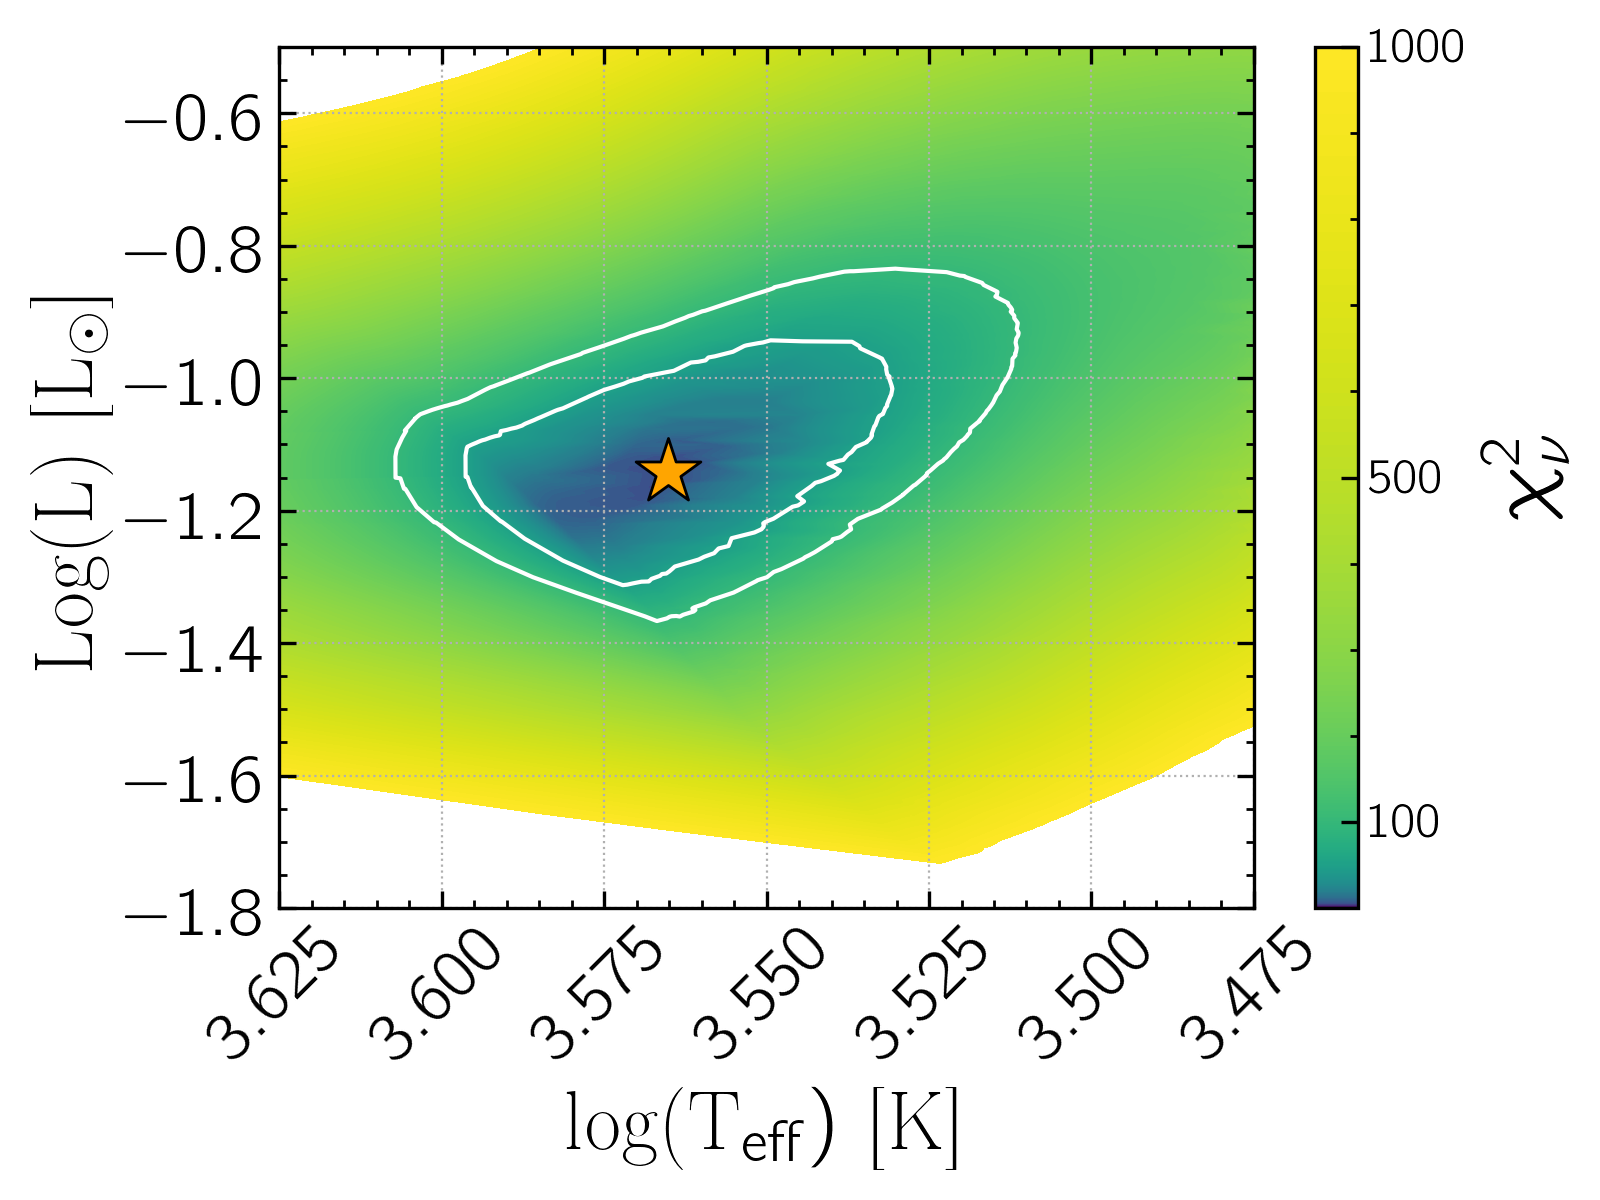

In [6]:
import matplotlib
from matplotlib.ticker import LogLocator, LogFormatter
l_f = LogFormatter(10)


plt.style.use('magrathea')
%matplotlib inline
plt.figure(figsize=(8,6))
plt.grid(ls=':')
levels = np.linspace(0,1000,1000)
im = plt.tricontourf(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, cmap = 'viridis', 
                norm=matplotlib.colors.LogNorm())
cbarticks = [100,500,1000]
cbar = plt.colorbar(im,ticks=cbarticks)
levels = [50,100]
CS = plt.tricontour(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, 
               colors=['w']*len(levels))
plt.clabel(CS, CS.levels, inline=True, fontsize=25, inline_spacing=0.5, use_clabeltext=True)

plt.scatter(mist['log_Teff'][ind[0]], mist['log_L'][ind[0]], color='orange', marker = '*',s=600, zorder=10, 
            edgecolors = 'black')

plt.xlim(3.475,3.625)
plt.ylim(-1.8,-0.5)
plt.gca().invert_xaxis()
cbar.set_label(r'$\chi_\nu^2$',fontsize=30)
plt.xlabel('log(T$_{\mathrm{eff}})$ [K]', fontsize=30)
plt.xticks(fontsize=25, rotation=45)
plt.ylabel('Log(L) [L$_{\odot}$]',fontsize=30)
plt.yticks(fontsize=25)
plt.tight_layout()

In [79]:
os.system('ls '+directory+'*chi2-output* > list')
with open('list') as z:
    ff = z.read().splitlines()
ff

['MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_m0.25_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output.csv',
 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_m0.50_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output.csv',
 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_m0.75_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output.csv',
 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_m1.00_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output.csv',
 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_m1.25_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output.csv',
 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_m1.50_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output.csv',
 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_m1.75_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output.csv',
 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_m2.00_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output.csv',
 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_

In [92]:
#mhs = [-0.25,-0.50,-0.75,-1.0,-1.25,-1.50,-1.75,-2.00,-2.50,-3.00,-4.00,0.00,0.25,0.50]
mhs = [-4.00,-3.50,-3.00,-2.50,-2.00,-1.50,-1.00,0.00,0.50]
mhs_strings = []
for i in range(len(mhs)):
    string = str(mhs[i])
    if '-' in string:
        string = string.replace('-','m')
    else:
        string = 'p'+string
    string += '0'
    mhs_strings.append(string)

file = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output.csv'
print(mhs_strings)
mist = pd.read_csv(file)

mist

['m4.00', 'm3.50', 'm3.00', 'm2.50', 'm2.00', 'm1.50', 'm1.00', 'p0.00', 'p0.50']


EEP  log10_isochrone_age_yr  initial_mass  star_mass  log_Teff  \
0          0                     5.0      0.100000   0.100000  3.411299   
1          1                     5.0      0.111815   0.111815  3.422598   
2          2                     5.0      0.115074   0.115074  3.425481   
3          3                     5.0      0.118346   0.118346  3.428410   
4          4                     5.0      0.121630   0.121630  3.431387   
...      ...                     ...           ...        ...       ...   
105371  1706                    10.3      0.925792   0.532726  4.402490   
105372  1707                    10.3      0.925825   0.532730  4.387132   
105373  1708                    10.3      0.925866   0.532735  4.371789   
105374  1709                    10.3      0.925919   0.532741  4.356480   
105375  1710                    10.3      0.925985   0.532749  4.341226   

           log_g     log_L  [Fe/H]_init    [Fe/H]     SDSS_u     SDSS_g  \
0       3.127863 -1.089873          0.5  0.590904  13.882782  13.366472   
1       3.086659 -0.961863          0.5  0.590904  13.427065  12.849765   
2       3.080135 -0.932329          0.5  0.590904  13.321877  12.726091   
3       3.073772 -0.902727          0.5  0.590904  13.216396  12.601705   
4       3.067583 -0.873066          0.5  0.590904  13.110641  12.476588   
...          ...       ...          ...       ...        ...        ...   
105371  7.777159 -1.047903          0.5  0.584570   9.590097   9.757511   
105372  7.783242 -1.115415          0.5  0.584574   9.704615   9.845963   
105373  7.789130 -1.182672          0.5  0.584578   9.815765   9.931186   
105374  7.794844 -1.249617          0.5  0.584584   9.924437  10.013835   
105375  7.800376 -1.316157          0.5  0.584591  10.031345  10.094429   

           SDSS_r     SDSS_i     SDSS_z  phase       g-r       r-i  \
0       12.447647   9.585422   7.821005   -1.0  0.918825  2.862225   
1       11.911878   9.150095   7.464259   -1.0  0.937887  2.761783   
2       11.779793   9.045739   7.380829   -1.0  0.946298  2.734054   
3       11.646404   8.940701   7.297115   -1.0  0.955301  2.705703   
4       11.511683   8.834982   7.213135   -1.0  0.964905  2.676701   
...           ...        ...        ...    ...       ...       ...   
105371  10.191074  10.532596  10.866735    6.0 -0.433563 -0.341522   
105372  10.270611  10.607910  10.939060    6.0 -0.424648 -0.337299   
105373  10.346869  10.679877  11.008009    6.0 -0.415683 -0.333008   
105374  10.420485  10.749150  11.074233    6.0 -0.406650 -0.328665   
105375  10.491980  10.816280  11.138297    6.0 -0.397551 -0.324300   

                chi2  
0        7173.775218  
1        4878.757827  
2        4413.714725  
3        3981.257695  
4        3582.042132  
...              ...  
105371  15742.475299  
105372  16462.294635  
105373  17167.534989  
105374  17862.480396  
105375  18551.139304  

[105376 rows x 18 columns]

In [ ]:

ind = np.argsort(mist['chi2'])

<IPython.core.display.Javascript object>


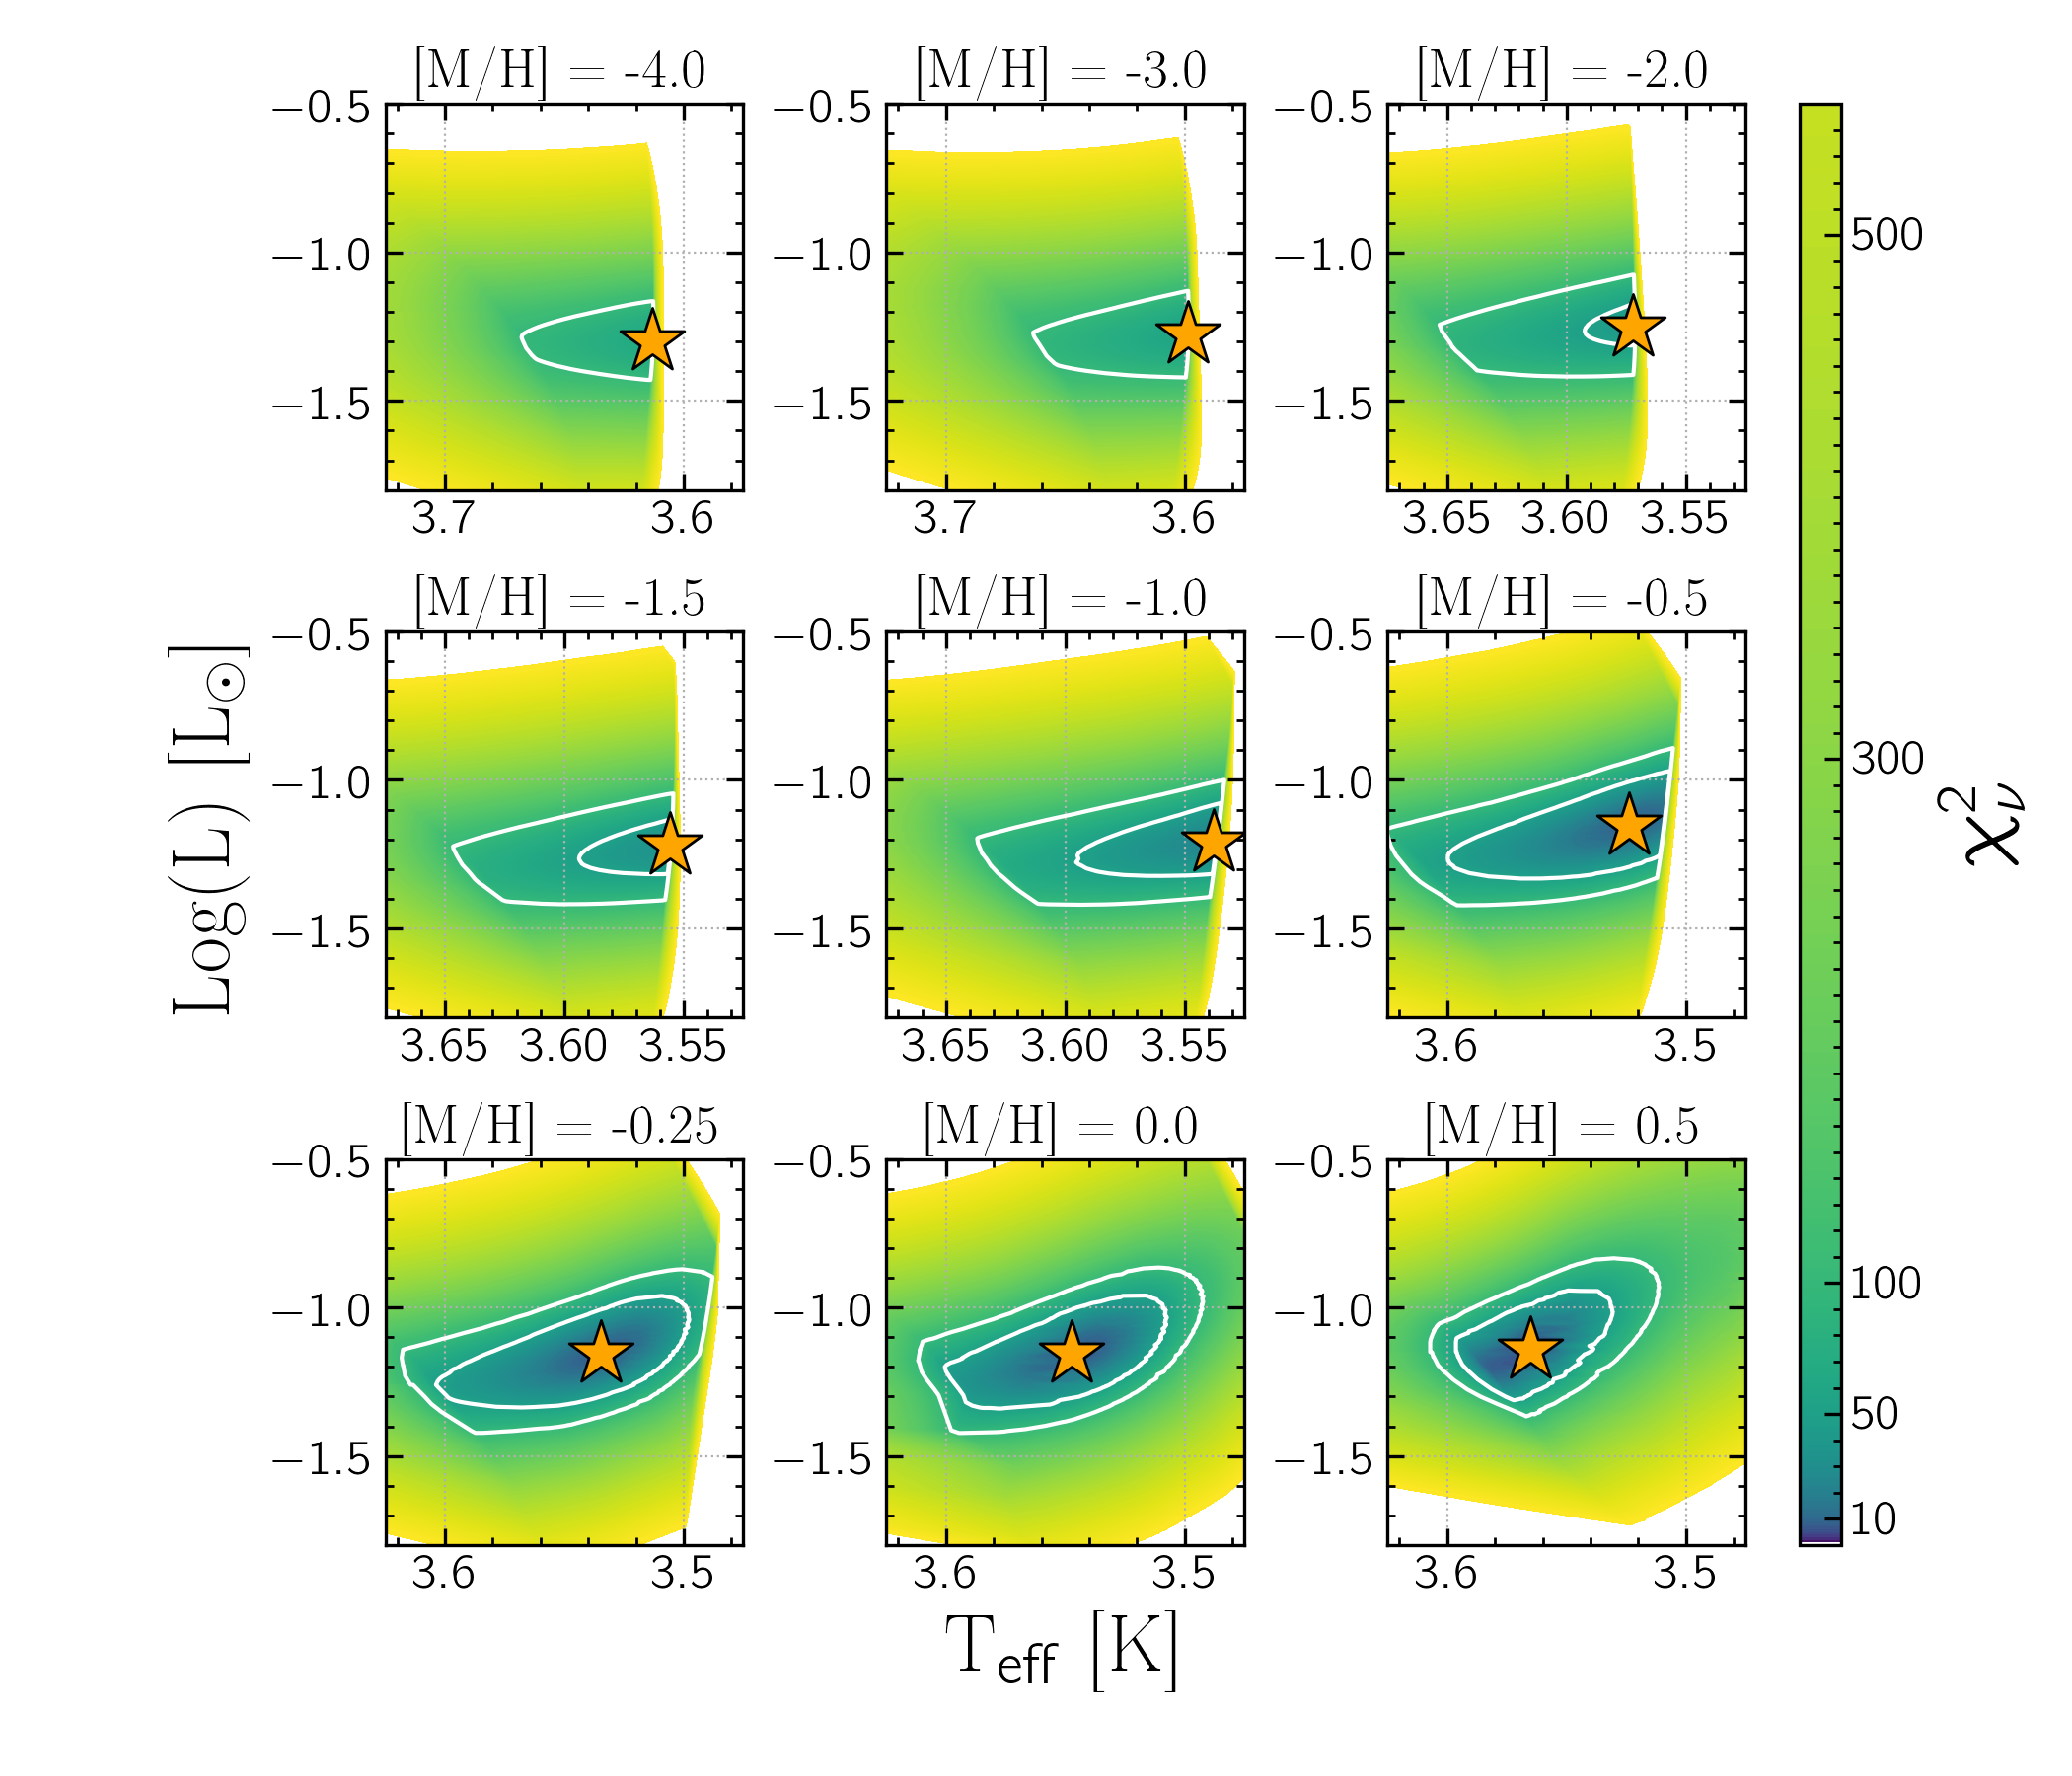

In [73]:
mhs = [-4.00,-3.00,-2.00,-1.50,-1.00,-0.50,-0.25,0.00,0.50]
mhs_strings = []
for i in range(len(mhs)):
    string = str(mhs[i])
    if '-' in string:
        string = string.replace('-','m')
    else:
        string = 'p'+string
    string += '0'
    mhs_strings.append(string)
mhs_strings[6] = mhs_strings[6].replace('m0.250','m0.25')

teffs_at_chimin = []
lums_at_chimin = []

import matplotlib
from matplotlib.ticker import LogLocator, LogFormatter
l_f = LogFormatter(10)
plt.style.use('magrathea')

import matplotlib.gridspec as gridspec

%matplotlib notebook
fig = plt.figure(figsize=(10.5,9))
gs = gridspec.GridSpec(nrows=3, ncols=3)

ax1 = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('T$_{\mathrm{eff}}$ [K]', fontsize=30)
plt.ylabel('Log(L) [L$_{\odot}$]',fontsize=30)
plt.gca().yaxis.set_label_coords(-0.1, 0.5)

row = [0,0,0,1,1,1,2,2,2]
column = [0,1,2,0,1,2,0,1,2]

for i in range(len(mhs)):

    ax0 = fig.add_subplot(gs[row[i],column[i]])
    string = mhs_strings[i]
    file = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output-C.csv'
    mist = pd.read_csv(file)
    ind = np.argsort(mist['chi2'])
    
    levels = np.linspace(0,1000,1000)
    im = ax0.tricontourf(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, cmap = 'viridis', 
                    norm=matplotlib.colors.LogNorm())
    levels = [50,100]
    CS = ax0.tricontour(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, 
                   colors=['w']*len(levels))
    ax0.clabel(CS, CS.levels, inline=True, fontsize=25, inline_spacing=0.5, use_clabeltext=True)

    ax0.scatter(mist['log_Teff'][ind[0]], mist['log_L'][ind[0]], color='orange', marker = '*',s=600, zorder=10, 
                edgecolors = 'black')
    ax0.set_title('[M/H] = '+str(mhs[i]))
    
    teffs_at_chimin.append(mist['log_Teff'][ind[0]])
    lums_at_chimin.append(mist['log_L'][ind[0]])

    if i in range(2):
        ax0.set_xlim(3.575,3.725)
    elif i in range(2,5):
        ax0.set_xlim(3.525,3.675)
    else:
        ax0.set_xlim(3.475,3.625)

    ax0.grid(ls=':')
    ax0.set_ylim(-1.8,-0.5)
    ax0.invert_xaxis()

    
cbarticks = [10, 50, 100, 300, 500]
cax = ax1.inset_axes([1.04, 0., 0.03, 1.0], transform=ax1.transAxes)
#cbar = fig.colorbar(x, ax=axes[1], cax=cax)
cbar = fig.colorbar(im, ax=ax1, cax=cax, ticks=cbarticks)
cbar.ax.set_ylim(top = 550)
cbar.set_label(r'$\chi_\nu^2$',fontsize=30)


plt.tight_layout()
plt.savefig('MIST_models_chi2MAP_C_primaryas_M0V-all-metalicities-vcrit0.0.png',
             dpi=300,
           bbox_inches = 'tight')
plt.savefig(
    'MIST_models_chi2MAP_C_primaryas_M0V_transparent-all-metalicities-vcrit0.0.png',
            dpi=300,transparent=True, bbox_inches = 'tight')

In [156]:
10**np.array(teffs_at_chimin),lums_at_chimin

(array([4102.61643731, 3969.25916598, 3733.11957018, 3594.41143159,
        3451.19394895, 3341.30570474, 3424.5380257 , 3528.3928622 ,
        3674.81107335]),
 [-1.2988301879860311,
  -1.277026313486666,
  -1.253392421331375,
  -1.221273932387434,
  -1.2117144419837806,
  -1.153962396353179,
  -1.1551122213261458,
  -1.1572493196423934,
  -1.1416260575031778])

In [1]:
mhs = [-4.00,-3.00,-2.00,-1.50,-1.00,-0.50,-0.25,0.00,0.50]
mhs_strings = []
for i in range(len(mhs)):
    string = str(mhs[i])
    if '-' in string:
        string = string.replace('-','m')
    else:
        string = 'p'+string
    string += '0'
    mhs_strings.append(string)
mhs_strings[6] = mhs_strings[6].replace('m0.250','m0.25')

mh_chi2s = []

for i in range(len(mhs_strings)):
    string = mhs_strings[i]
    file = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output.csv'
    mist = pd.read_csv(file)
    print(string,np.min(mist['chi2'])/6)
    mh_chi2s.append(np.min(mist['chi2'])/6)
mh_chi2s

m4.00 51.08883684980572
m3.00 44.72021327804813
m2.00 32.977837700335165
m1.50 26.627741893726114
m1.00 17.923496232432125
m0.50 6.585463419705131
m0.25 5.414142281731775
p0.00 4.465422673992921
p0.50 3.350123338608322


[51.08883684980572,
 44.72021327804813,
 32.977837700335165,
 26.627741893726114,
 17.923496232432125,
 6.585463419705131,
 5.414142281731775,
 4.465422673992921,
 3.350123338608322]

m4.00 51.08883684980572
m3.00 44.72021327804813
m2.00 32.977837700335165
m1.50 26.627741893726114
m1.00 17.923496232432125
m0.50 6.585463419705131
m0.25 5.414142281731775
p0.00 4.465422673992921
p0.50 3.350123338608322


<IPython.core.display.Javascript object>


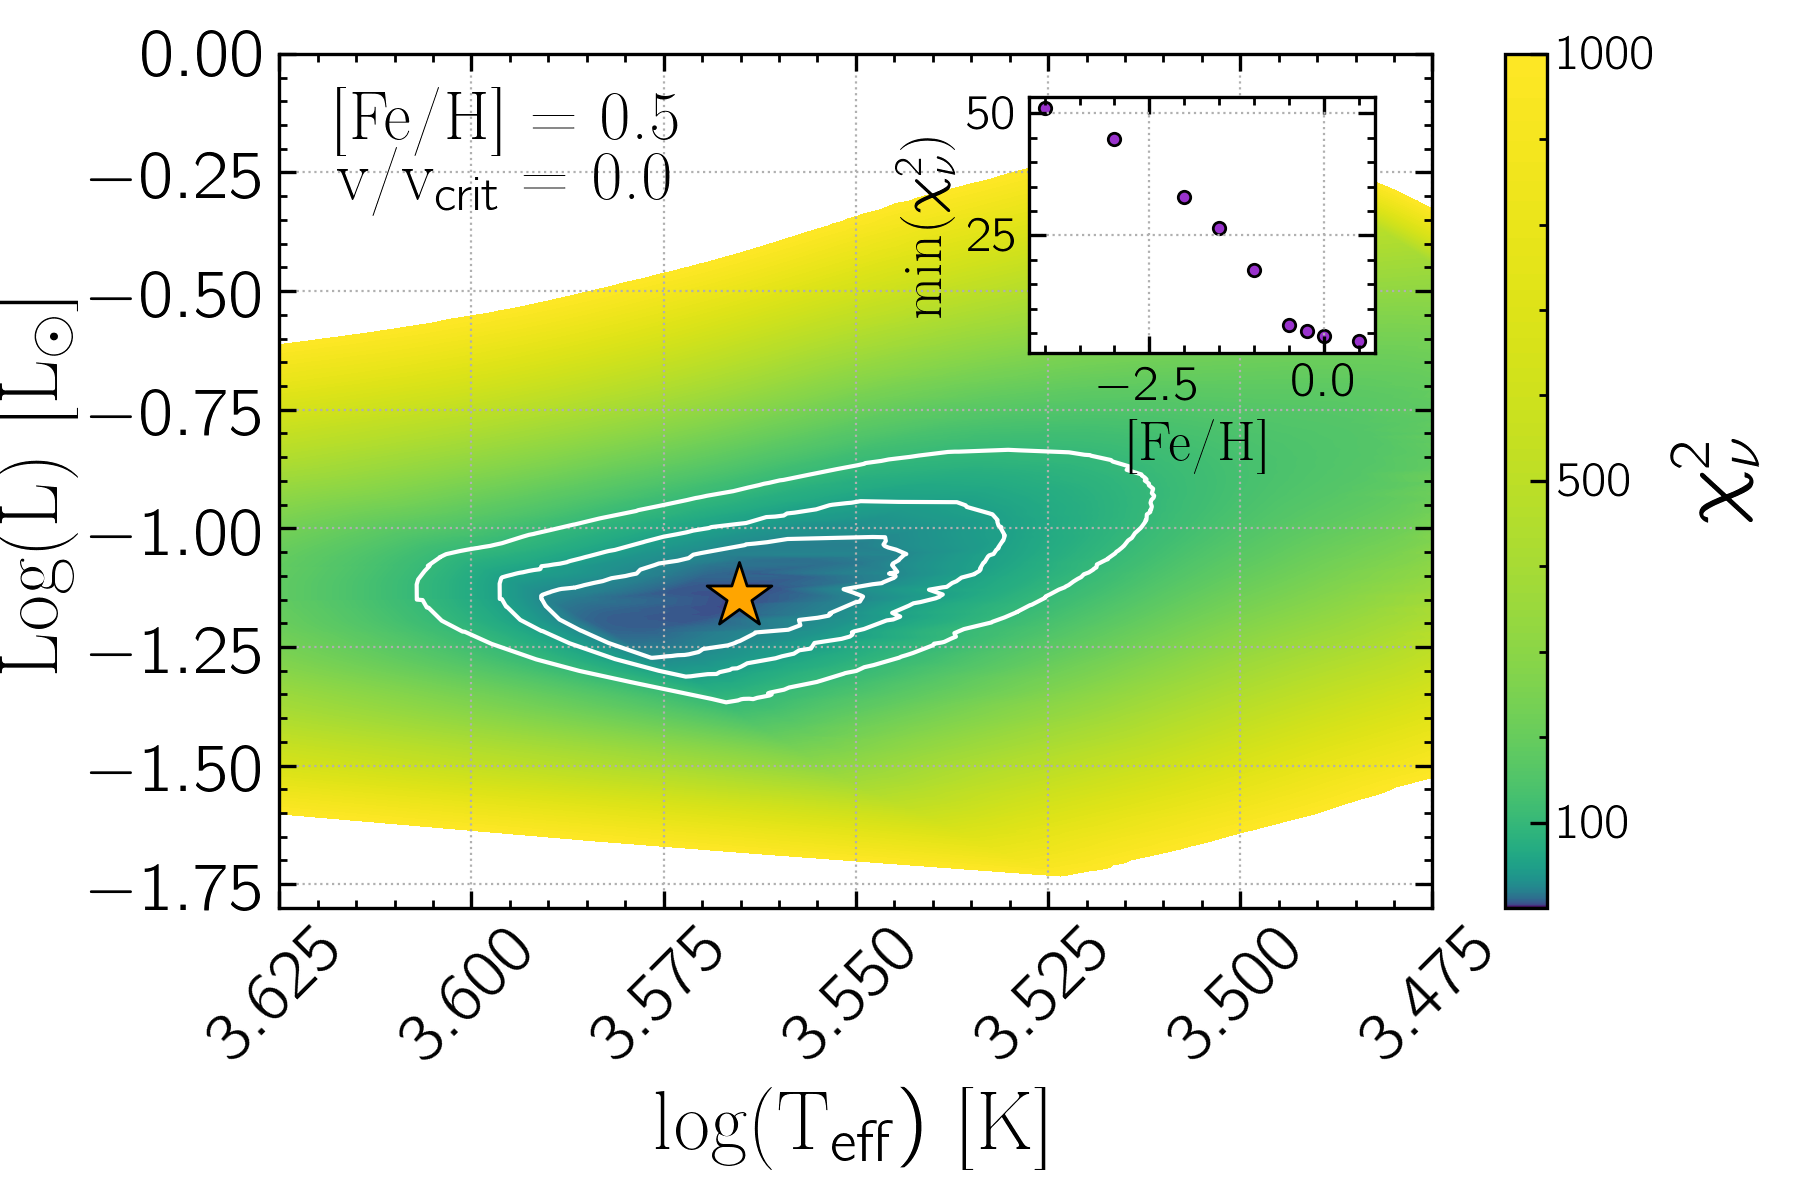

In [83]:
mhs = [-4.00,-3.00,-2.00,-1.50,-1.00,-0.50,-0.25,0.00,0.50]
mhs_strings = []
for i in range(len(mhs)):
    string = str(mhs[i])
    if '-' in string:
        string = string.replace('-','m')
    else:
        string = 'p'+string
    string += '0'
    mhs_strings.append(string)
mhs_strings[6] = mhs_strings[6].replace('m0.250','m0.25')

mh_chi2s = []

for i in range(len(mhs_strings)):
    string = mhs_strings[i]
    file = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output-C.csv'
    mist = pd.read_csv(file)
    print(string,np.min(mist['chi2'])/6)
    mh_chi2s.append(np.min(mist['chi2'])/6)



directory = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/'
mist = pd.read_csv(directory+'MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output-C.csv')
ind = np.argsort(mist['chi2'])

import matplotlib
from matplotlib.ticker import LogLocator, LogFormatter
l_f = LogFormatter(10)


plt.style.use('magrathea')
%matplotlib notebook
plt.figure(figsize = (9,6))
plt.grid(ls=':')
levels = np.linspace(0,1000,1000)
im = plt.tricontourf(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, cmap = 'viridis', 
                norm=matplotlib.colors.LogNorm())
cbarticks = [100,500,1000]
cbar = plt.colorbar(im,ticks=cbarticks)
#levels = [(mist['chi2'][ind[0]])/6+1,25, 50, 100]
clevels = [25, 50, 100]
CS = plt.tricontour(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = clevels, 
               colors=['w']*len(levels))
plt.clabel(CS, CS.levels, inline=True, fontsize=15, inline_spacing=0.5, use_clabeltext=True)

plt.scatter(mist['log_Teff'][ind[0]], mist['log_L'][ind[0]], color='orange', marker = '*',s=600, zorder=10, 
            edgecolors = 'black')

plt.annotate('[Fe/H] = 0.5',xy = (0.05,0.9), xycoords = 'axes fraction', fontsize=25)
plt.annotate('v/v$_\mathrm{crit}$ = 0.0',xy = (0.05,0.83), xycoords = 'axes fraction', fontsize=25)

plt.xlim(3.475,3.625)
plt.ylim(-1.8,0)
plt.gca().invert_xaxis()
cbar.set_label(r'$\chi_\nu^2$',fontsize=30)
plt.xlabel('log(T$_{\mathrm{eff}})$ [K]', fontsize=30)
plt.xticks(fontsize=25, rotation=45)
plt.ylabel('Log(L) [L$_{\odot}$]',fontsize=30)
plt.yticks(fontsize=25)

######################## inset axes #######
ax = plt.gca()
axins = ax.inset_axes([0.65, 0.65, 0.3, 0.3])
axins.scatter(mhs, mh_chi2s, marker="o", ls='None', s=20, color='darkorchid',edgecolor='black')
axins.grid(ls=':')
axins.set_xlabel('[Fe/H]')
axins.set_ylabel(r'min($\chi_\nu^2$)')


plt.tight_layout()

#plt.savefig('MIST_models_chi2MAP_C_primaryas_M0V-mh_p05_wchi2plot.png',dpi=300,bbox_inches = 'tight')

In [7]:
#m = np.array([mist['log_Teff'], mist['log_L'], mist['chi2']/5])
ind = np.where((mist['log_Teff'] > 3.475) & (mist['log_Teff'] < 3.625))[0]
ind2 = np.where((mist['log_L'] > -1.75) & (mist['log_L'] < 0))[0]
Larray = mist['log_L'][ind2]
xx, yy = np.meshgrid(mist['log_Teff'][ind],mist['log_L'][ind2])
xx.shape,yy.shape

((8267, 24613), (8267, 24613))

In [9]:
mist

EEP  log10_isochrone_age_yr  initial_mass  star_mass  log_Teff  \
0          0                     5.0      0.100000   0.100000  3.411299   
1          1                     5.0      0.111815   0.111815  3.422598   
2          2                     5.0      0.115074   0.115074  3.425481   
3          3                     5.0      0.118346   0.118346  3.428410   
4          4                     5.0      0.121630   0.121630  3.431387   
...      ...                     ...           ...        ...       ...   
105371  1706                    10.3      0.925792   0.532726  4.402490   
105372  1707                    10.3      0.925825   0.532730  4.387132   
105373  1708                    10.3      0.925866   0.532735  4.371789   
105374  1709                    10.3      0.925919   0.532741  4.356480   
105375  1710                    10.3      0.925985   0.532749  4.341226   

           log_g     log_L  [Fe/H]_init    [Fe/H]     SDSS_u     SDSS_g  \
0       3.127863 -1.089873          0.5  0.590904  13.882782  13.366472   
1       3.086659 -0.961863          0.5  0.590904  13.427065  12.849765   
2       3.080135 -0.932329          0.5  0.590904  13.321877  12.726091   
3       3.073772 -0.902727          0.5  0.590904  13.216396  12.601705   
4       3.067583 -0.873066          0.5  0.590904  13.110641  12.476588   
...          ...       ...          ...       ...        ...        ...   
105371  7.777159 -1.047903          0.5  0.584570   9.590097   9.757511   
105372  7.783242 -1.115415          0.5  0.584574   9.704615   9.845963   
105373  7.789130 -1.182672          0.5  0.584578   9.815765   9.931186   
105374  7.794844 -1.249617          0.5  0.584584   9.924437  10.013835   
105375  7.800376 -1.316157          0.5  0.584591  10.031345  10.094429   

           SDSS_r     SDSS_i     SDSS_z  phase       g-r       r-i  \
0       12.447647   9.585422   7.821005   -1.0  0.918825  2.862225   
1       11.911878   9.150095   7.464259   -1.0  0.937887  2.761783   
2       11.779793   9.045739   7.380829   -1.0  0.946298  2.734054   
3       11.646404   8.940701   7.297115   -1.0  0.955301  2.705703   
4       11.511683   8.834982   7.213135   -1.0  0.964905  2.676701   
...           ...        ...        ...    ...       ...       ...   
105371  10.191074  10.532596  10.866735    6.0 -0.433563 -0.341522   
105372  10.270611  10.607910  10.939060    6.0 -0.424648 -0.337299   
105373  10.346869  10.679877  11.008009    6.0 -0.415683 -0.333008   
105374  10.420485  10.749150  11.074233    6.0 -0.406650 -0.328665   
105375  10.491980  10.816280  11.138297    6.0 -0.397551 -0.324300   

                chi2  
0        7173.775218  
1        4878.757827  
2        4413.714725  
3        3981.257695  
4        3582.042132  
...              ...  
105371  15742.475299  
105372  16462.294635  
105373  17167.534989  
105374  17862.480396  
105375  18551.139304  

[105376 rows x 18 columns]

In [36]:
xx, yy = np.meshgrid(mist['log_Teff'][ind3],mist['log_L'][ind3])
xx.shape,yy.shape
teff_chimin_ind = np.where(xx == teff_chimin)

%matplotlib notebook
plt.plot(yy[0],)

(array([   0,    1,    2, ..., 3187, 3188, 3189]),
 array([1980, 1980, 1980, ..., 1980, 1980, 1980]))

In [32]:
ind = np.where((mist['log_Teff'] > 3.475) & (mist['log_Teff'] < 3.625))[0]
ind2 = np.where((mist['log_L'] > -1.75) & (mist['log_L'] < 0))[0]
ind3 = np.where((mist['log_Teff'] > 3.475) & (mist['log_Teff'] < 3.625) & (mist['log_L'] > -1.75)
                & (mist['log_L'] < 0))[0]
teff_array = mist['log_Teff'][ind3]
teff_array = teff_array.reset_index(drop=True)
lum_array = mist['log_L'][ind3]
lum_array = lum_array.reset_index(drop=True)
chi_array = mist['chi2'][ind3]
ind4 = np.argsort(chi_array)
ind4 = ind4.reset_index(drop=True)

C_teff_chimin = teff_array[ind4[0]]
C_lum_chimin = lum_array[ind4[0]]
teff

<IPython.core.display.Javascript object>


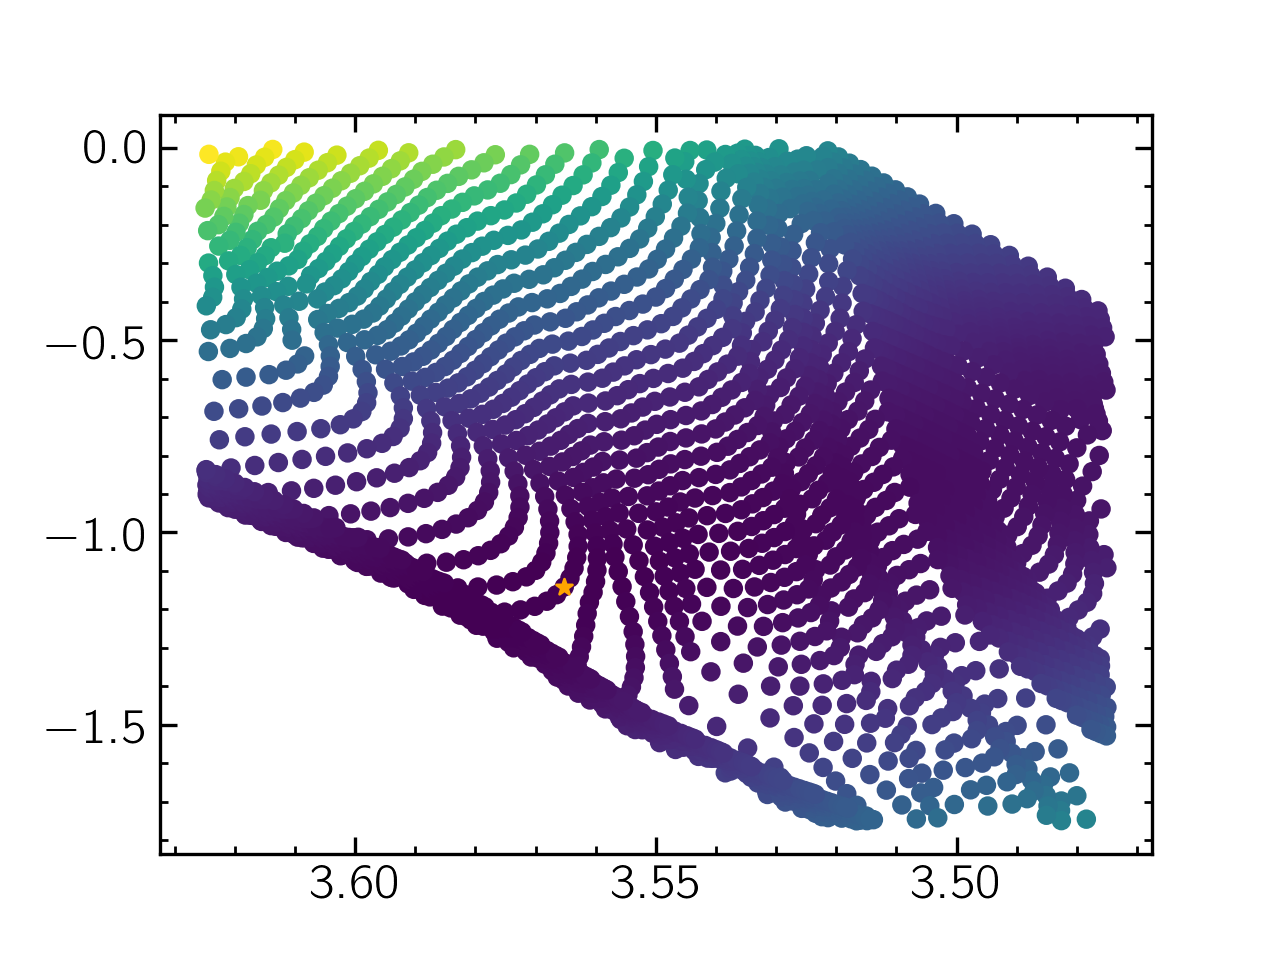

In [35]:
%matplotlib notebook
plt.scatter(teff_array,lum_array,c=chi_array,cmap='viridis')
plt.scatter(teff_chimin,lum_chimin,color='orange',marker='*')
plt.gca().invert_xaxis()

<IPython.core.display.Javascript object>


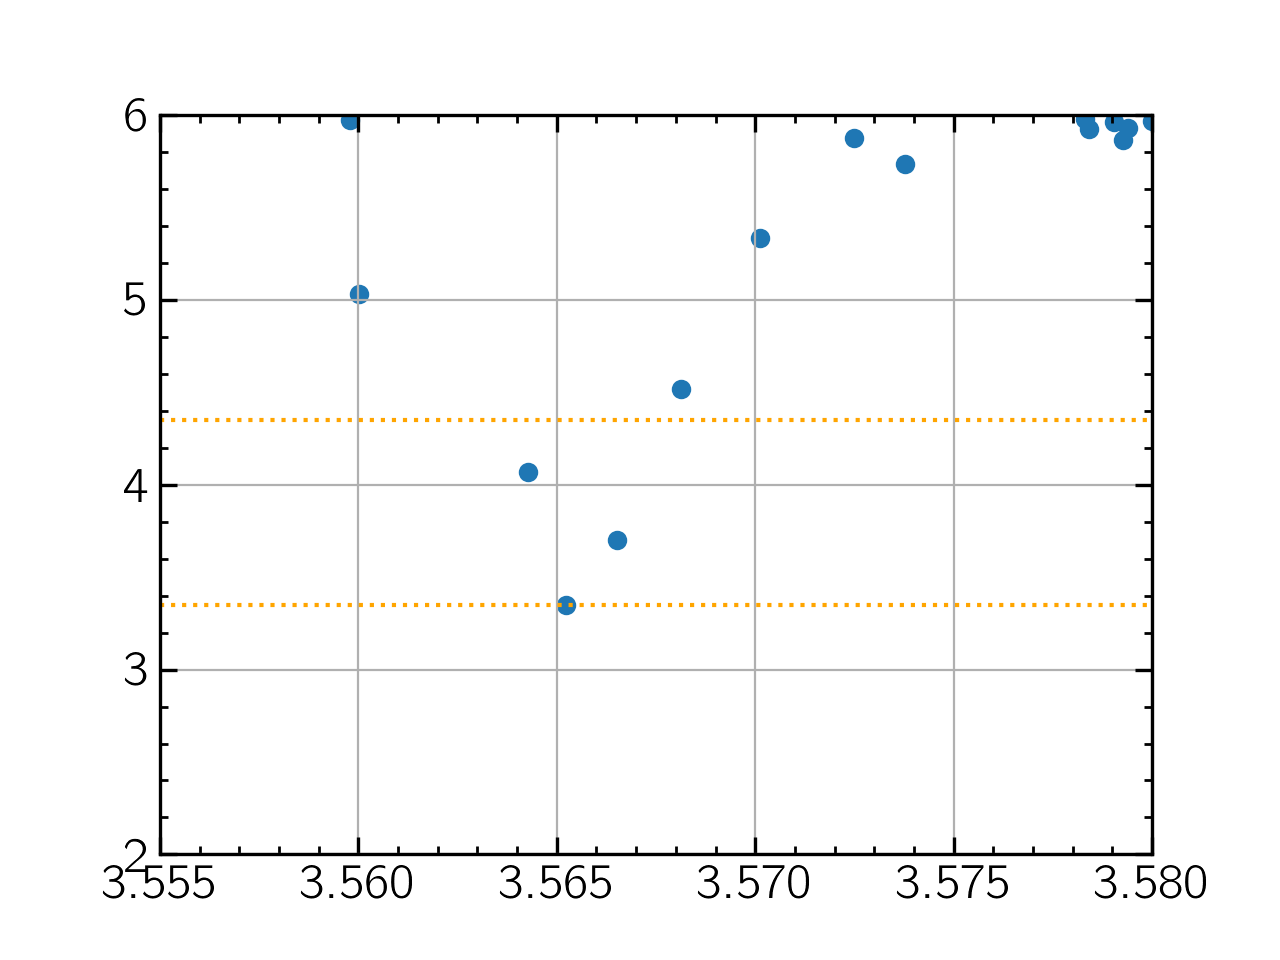

In [51]:
from scipy.interpolate import UnivariateSpline
ind = np.where(mist['chi2']/6 < 5.5)
#spl = UnivariateSpline(mist['chi2']/6,mist['log_Teff'])
#T_l = spl()

%matplotlib notebook
plt.scatter(mist['log_Teff'],mist['chi2']/6)
plt.axhline(y=np.min(mist['chi2']/6),color='orange',ls=':')
plt.axhline(y=np.min(mist['chi2']/6)+1,color='orange',ls=':')
#plt.scatter()
plt.xlim(3.555,3.58)
plt.ylim(2,6)
plt.grid()

In [41]:
logTeff_max = 3.56806
logTeff_min = 3.56157
10**logTeff_max,10**logTeff_min,10**teff_chimin

(3698.7927696107704, 3643.9297854424094, 3674.8110733548638)

<IPython.core.display.Javascript object>


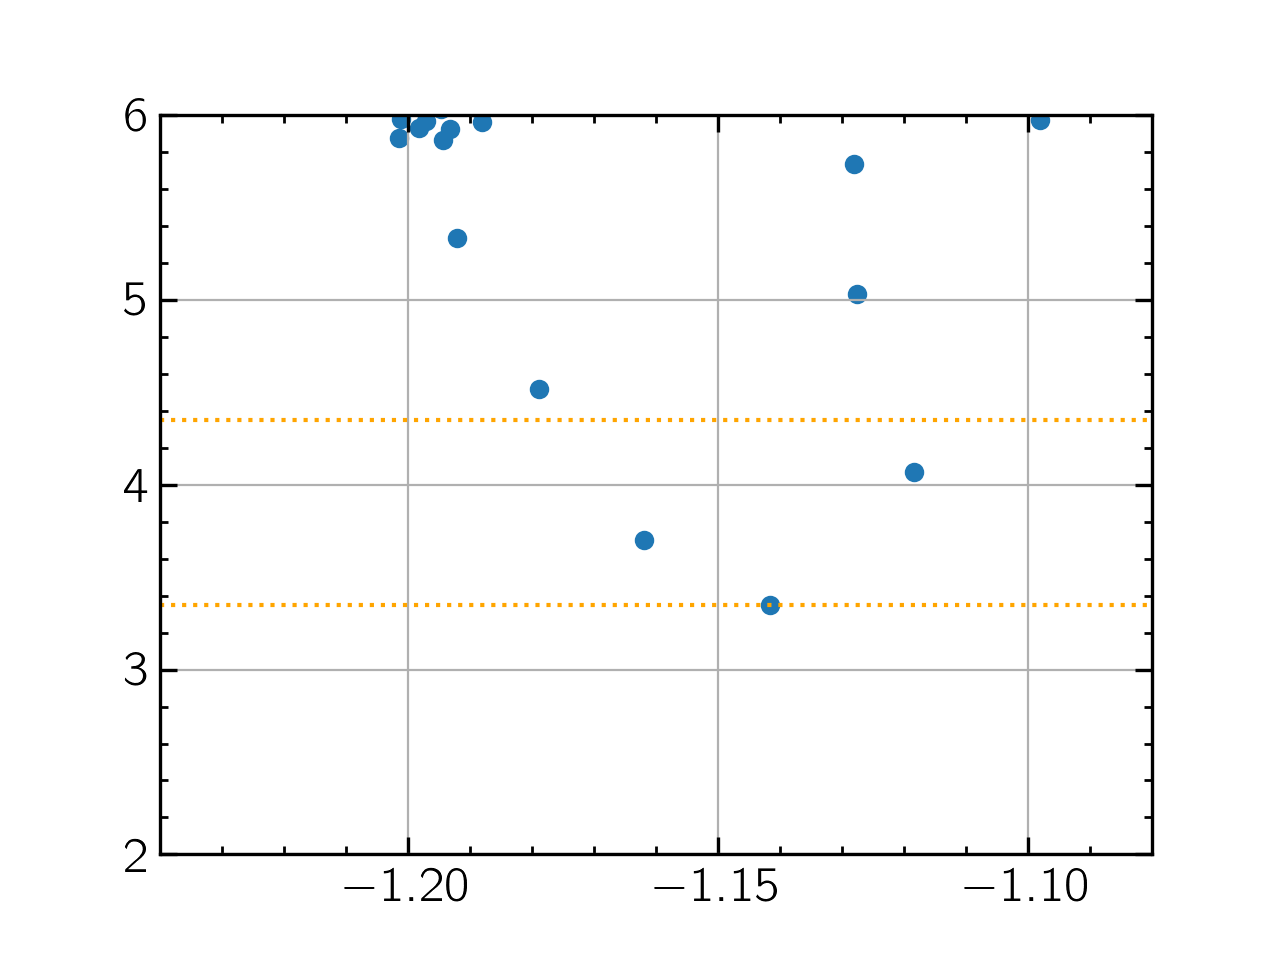

(-1.1762, -1.1242, -1.1416260575031778)

In [52]:
%matplotlib notebook
plt.scatter(mist['log_L'],mist['chi2']/6)
plt.axhline(y=np.min(mist['chi2']/6),color='orange',ls=':')
plt.axhline(y=np.min(mist['chi2']/6)+1,color='orange',ls=':')
#plt.scatter()
plt.xlim(-1.24,-1.08)
plt.ylim(2,6)
plt.grid()

logL_max = -1.1762
logL_min = -1.1242
logL_max,logL_min,lum_chimin

In [116]:
string = mhs_strings[-1]
file = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
    '_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output.csv'
mist = pd.read_csv(file)
ind = np.where(mist['chi2'] == np.min(mist['chi2']))[0]
print(string,mist['chi2'].loc[ind])
print(10**mist['log10_isochrone_age_yr'].loc[ind]/1e6)
print(10**mist['log_Teff'].loc[ind])
print(mist['log_L'].loc[ind])

p0.50 26364    20.10074
Name: chi2, dtype: float64
26364    44.668359
Name: log10_isochrone_age_yr, dtype: float64
26364    3674.811073
Name: log_Teff, dtype: float64
26364   -1.141626
Name: log_L, dtype: float64


# Repeat for v/vcrit = 0.4

In [62]:
Amag_SDSS,e_Amag_SDSS,Cmag_SDSS,e_Cmag_SDSS = pickle.load(open('SDSS-magnitudes.pkl','rb'))

from myastrotools.tools import MonteCarloIt, update_progress

Cmag_SDSS_dict = {'z':Cmag_SDSS[0],'i':Cmag_SDSS[1],'r':Cmag_SDSS[2],'g':Cmag_SDSS[3]}
e_Cmag_SDSS_dict = {'z':e_Cmag_SDSS[0],'i':e_Cmag_SDSS[1],'r':e_Cmag_SDSS[2],'g':e_Cmag_SDSS[3]}

Amag_SDSS_dict = {'z':Amag_SDSS[0],'i':Amag_SDSS[1],'r':Amag_SDSS[2],'g':Amag_SDSS[3]}
e_Amag_SDSS_dict = {'z':e_Amag_SDSS[0],'i':e_Amag_SDSS[1],'r':e_Amag_SDSS[2],'g':e_Amag_SDSS[3]}

CRminusI = MonteCarloIt([Cmag_SDSS_dict['r'],e_Cmag_SDSS_dict['r']]) - \
            MonteCarloIt([Cmag_SDSS_dict['i'],e_Cmag_SDSS_dict['i']])
CGminusR = MonteCarloIt([Cmag_SDSS_dict['g'],e_Cmag_SDSS_dict['g']]) - \
            MonteCarloIt([Cmag_SDSS_dict['r'],e_Cmag_SDSS_dict['r']])

ARminusI = MonteCarloIt([Amag_SDSS_dict['r'],e_Amag_SDSS_dict['r']]) - \
            MonteCarloIt([Amag_SDSS_dict['i'],e_Amag_SDSS_dict['i']])
AGminusR = MonteCarloIt([Amag_SDSS_dict['g'],e_Amag_SDSS_dict['g']]) - \
            MonteCarloIt([Amag_SDSS_dict['r'],e_Amag_SDSS_dict['r']])

Adistance = [220,2]

C_Mr = MonteCarloIt([Cmag_SDSS_dict['r'],e_Cmag_SDSS_dict['r']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
A_Mr = MonteCarloIt([Amag_SDSS_dict['r'],e_Amag_SDSS_dict['r']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
C_Mg = MonteCarloIt([Cmag_SDSS_dict['g'],e_Cmag_SDSS_dict['g']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
A_Mg = MonteCarloIt([Amag_SDSS_dict['g'],e_Amag_SDSS_dict['g']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
C_Mi = MonteCarloIt([Cmag_SDSS_dict['i'],e_Cmag_SDSS_dict['i']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
A_Mi = MonteCarloIt([Amag_SDSS_dict['i'],e_Amag_SDSS_dict['i']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
C_Mz = MonteCarloIt([Cmag_SDSS_dict['z'],e_Cmag_SDSS_dict['z']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
A_Mz = MonteCarloIt([Amag_SDSS_dict['z'],e_Amag_SDSS_dict['z']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5

#mist['chi2'] = np.nan

CM = [np.mean(C_Mg),np.mean(C_Mr),np.mean(C_Mi),np.mean(C_Mz)]
eCM = [np.std(C_Mg),np.std(C_Mr),np.std(C_Mi),np.std(C_Mz)]
CMIST = ['SDSS_g','SDSS_r','SDSS_i','SDSS_z']

colorlist = [np.mean(CRminusI),np.mean(CGminusR)]
ecolorlist = [np.std(CRminusI),np.std(CGminusR)]
colormist = ['r-i','g-r']

In [60]:
directory = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/'
os.system('ls '+directory+'* > list')

import warnings
warnings.filterwarnings('ignore')

mhs = [-0.25,-0.50,-0.75,-1.00,-1.25,-1.50,-1.75,-2.00,-2.50,-3.00,-3.50,-4.00,+0.00,+0.25,+0.5]
with open('list') as z:
    ff = z.read().splitlines()
    

count = 0
print(len(ff))
for file in ff[:0]:
    print(count)
    mist = pd.read_table(file, delim_whitespace = True, comment = "#",
                    names = ['EEP','log10_isochrone_age_yr','initial_mass','star_mass','log_Teff',\
                             'log_g','log_L','[Fe/H]_init','[Fe/H]','SDSS_u','SDSS_g','SDSS_r',\
                             'SDSS_i','SDSS_z','phase'])
    mist['g-r'] = mist['SDSS_g'] - mist['SDSS_r']
    mist['r-i'] = mist['SDSS_r'] - mist['SDSS_i']
    mist['chi2'] = np.nan
    for i in range(len(mist)):
        chisq = np.sum([( (CM[j]-mist[CMIST[j]][i]) / eCM[j] )**2 for j in range(4)])
        chisq += np.sum( [( (colorlist[j]-mist[colormist[j]][i]) / ecolorlist[j] )**2 for j in range(2)] )
        mist['chi2'][i] = chisq
        update_progress(i,len(mist))
    mist.to_csv(file+'--chi2-output.csv', index=False)
    count += 1
    print()
    del mist
os.system('say "Done"')

29


0

# C, v/vcrit=0.4

<IPython.core.display.Javascript object>


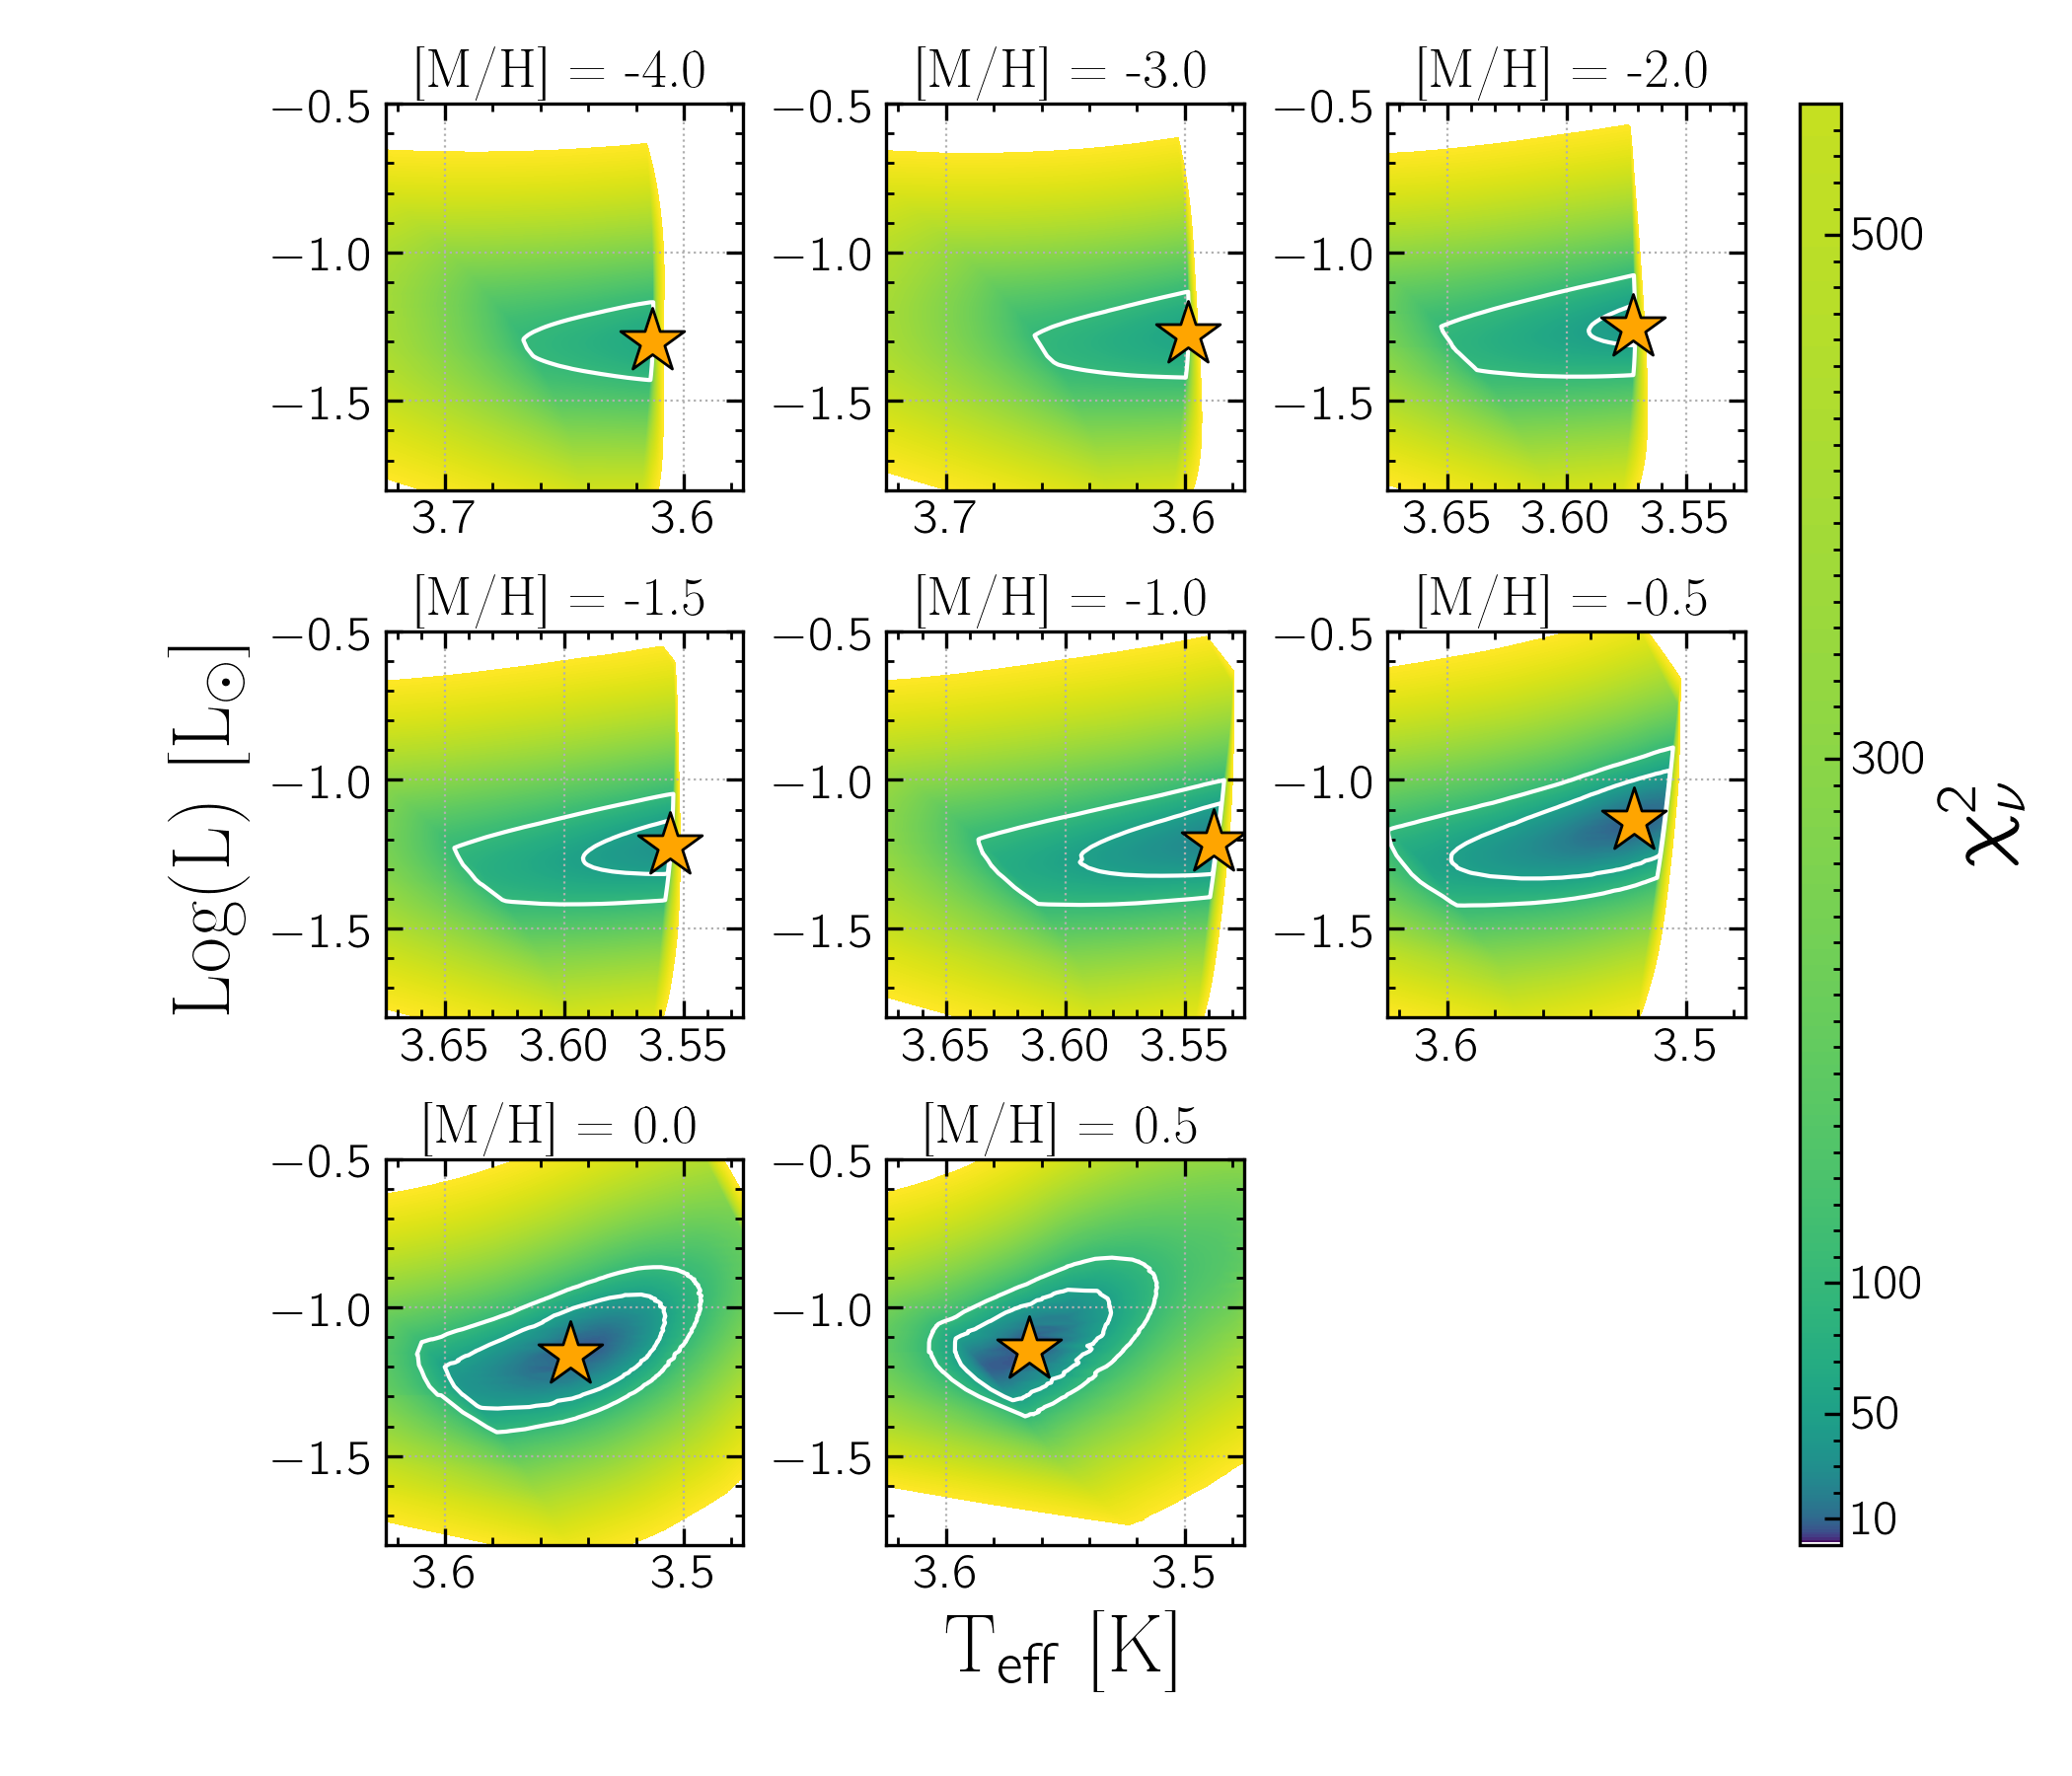

In [129]:
mhs = [-4.00,-3.00,-2.00,-1.50,-1.00,-0.50,0.00,0.50]
mhs_strings = []
for i in range(len(mhs)):
    string = str(mhs[i])
    if '-' in string:
        string = string.replace('-','m')
    else:
        string = 'p'+string
    string += '0'
    mhs_strings.append(string)
mhs_strings[6] = mhs_strings[6].replace('m0.250','m0.25')

teffs_at_chimin = []
lums_at_chimin = []

import matplotlib
from matplotlib.ticker import LogLocator, LogFormatter
l_f = LogFormatter(10)
plt.style.use('magrathea')

import matplotlib.gridspec as gridspec

%matplotlib notebook
fig = plt.figure(figsize=(10.5,9))
gs = gridspec.GridSpec(nrows=3, ncols=3)

ax1 = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('T$_{\mathrm{eff}}$ [K]', fontsize=30)
plt.ylabel('Log(L) [L$_{\odot}$]',fontsize=30)
plt.gca().yaxis.set_label_coords(-0.1, 0.5)

row = [0,0,0,1,1,1,2,2,2]
column = [0,1,2,0,1,2,0,1,2]

for i in range(len(mhs)):

    ax0 = fig.add_subplot(gs[row[i],column[i]])
    string = mhs_strings[i]
    file = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd--chi2-output-C.csv'
    mist = pd.read_csv(file)
    ind = np.argsort(mist['chi2'])
    
    levels = np.linspace(0,1000,1000)
    im = ax0.tricontourf(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, cmap = 'viridis', 
                    norm=matplotlib.colors.LogNorm())
    levels = [50,100]
    CS = ax0.tricontour(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, 
                   colors=['w']*len(levels))
    ax0.clabel(CS, CS.levels, inline=True, fontsize=25, inline_spacing=0.5, use_clabeltext=True)

    ax0.scatter(mist['log_Teff'][ind[0]], mist['log_L'][ind[0]], color='orange', marker = '*',s=600, zorder=10, 
                edgecolors = 'black')
    ax0.set_title('[M/H] = '+str(mhs[i]))
    
    teffs_at_chimin.append(mist['log_Teff'][ind[0]])
    lums_at_chimin.append(mist['log_L'][ind[0]])

    if i in range(2):
        ax0.set_xlim(3.575,3.725)
    elif i in range(2,5):
        ax0.set_xlim(3.525,3.675)
    else:
        ax0.set_xlim(3.475,3.625)

    ax0.grid(ls=':')
    ax0.set_ylim(-1.8,-0.5)
    ax0.invert_xaxis()

    
cbarticks = [10, 50, 100, 300, 500]
cax = ax1.inset_axes([1.04, 0., 0.03, 1.0], transform=ax1.transAxes)
#cbar = fig.colorbar(x, ax=axes[1], cax=cax)
cbar = fig.colorbar(im, ax=ax1, cax=cax, ticks=cbarticks)
cbar.ax.set_ylim(top = 550)
cbar.set_label(r'$\chi_\nu^2$',fontsize=30)


plt.tight_layout()
plt.savefig('MIST_models_chi2MAP_C_primaryas_M0V-all-metalicities-vcrit0.4.png',
             dpi=300,
           bbox_inches = 'tight')
plt.savefig(
    'MIST_models_chi2MAP_C_primaryas_M0V_transparent-all-metalicities-vcrit0.4.png',
            dpi=300,transparent=True, bbox_inches = 'tight')

m4.00 52.001799290747556
m3.00 45.541236128176706
m2.00 33.564369017302354
m1.50 27.148004617284613
m1.00 18.208501737264804
m0.50 6.550836673512053
p0.00 4.412841637323932
p0.50 3.289579681943277


<IPython.core.display.Javascript object>


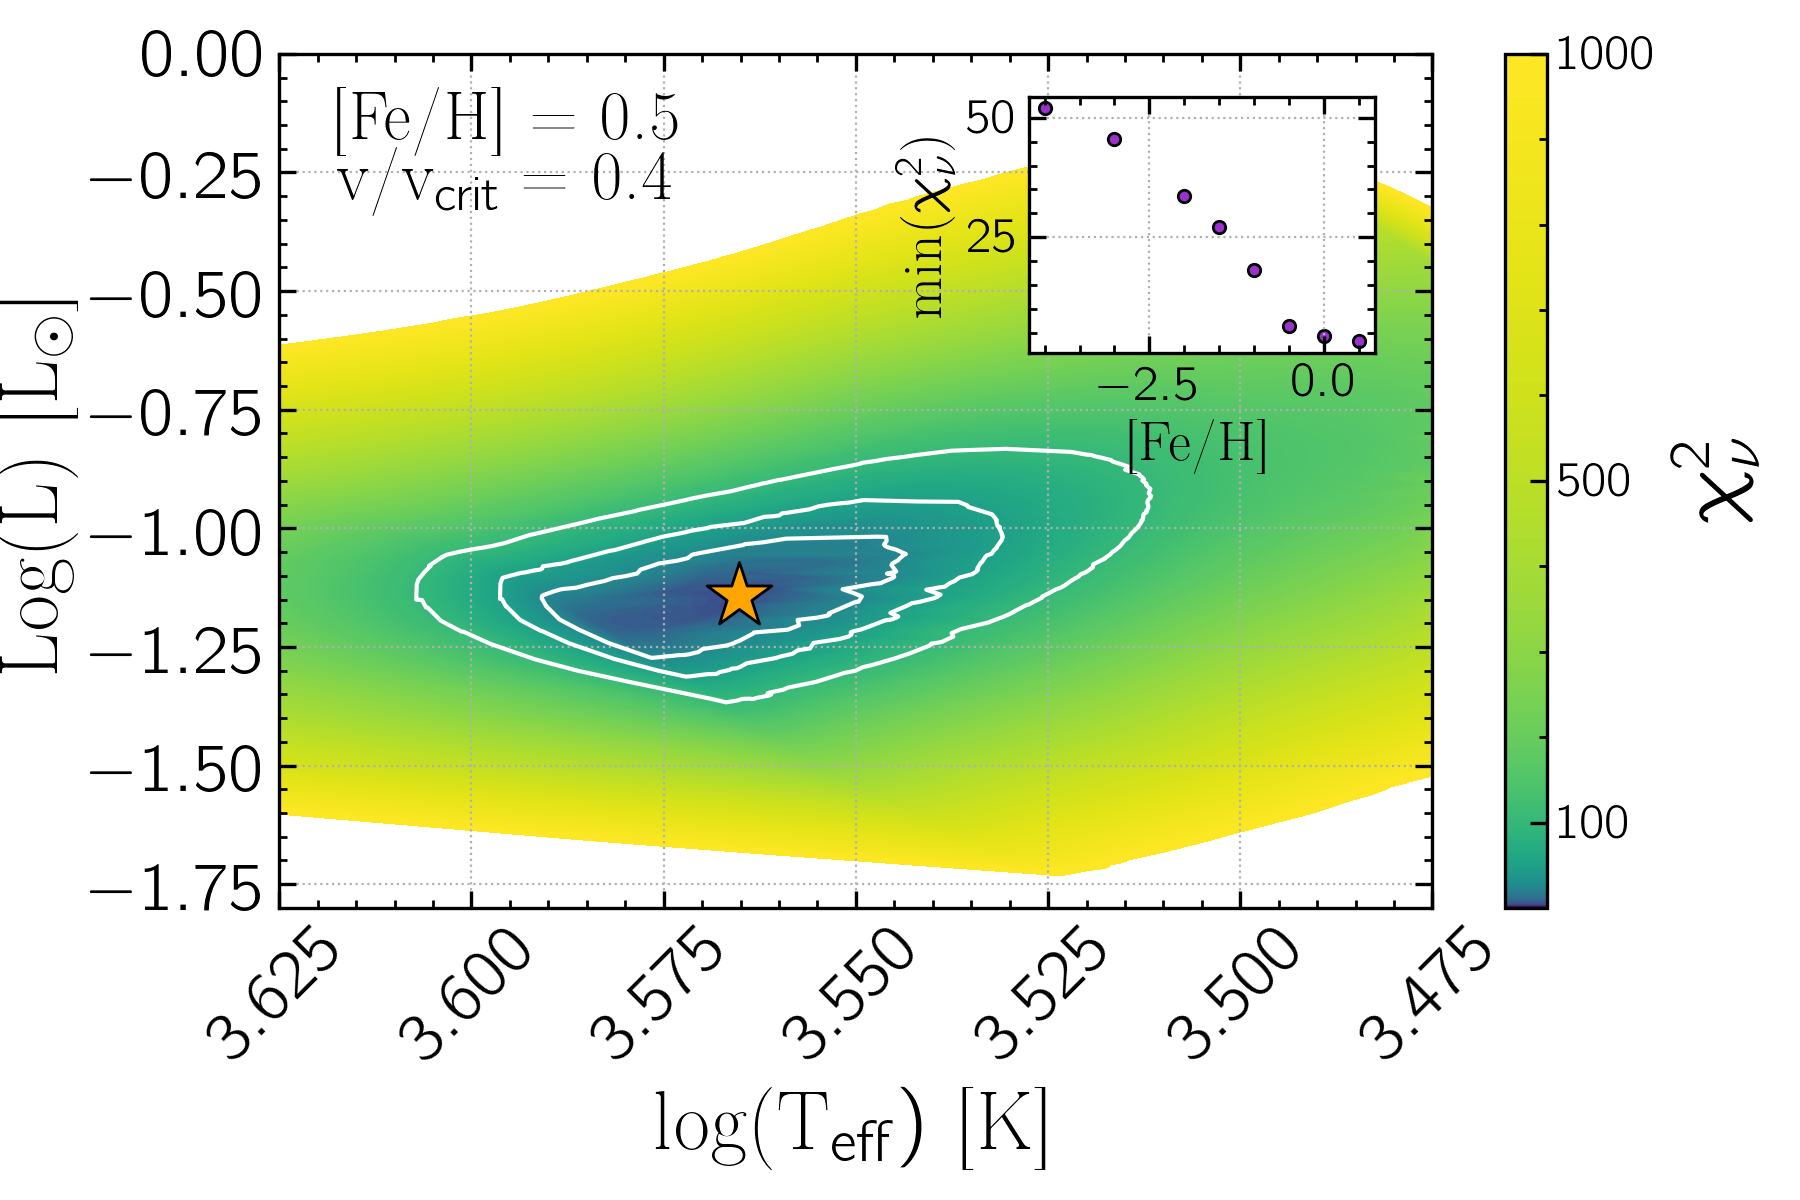

In [130]:
mhs = [-4.00,-3.00,-2.00,-1.50,-1.00,-0.50,0.00,0.50]
mhs_strings = []
for i in range(len(mhs)):
    string = str(mhs[i])
    if '-' in string:
        string = string.replace('-','m')
    else:
        string = 'p'+string
    string += '0'
    mhs_strings.append(string)
mhs_strings[6] = mhs_strings[6].replace('m0.250','m0.25')

mh_chi2s = []

for i in range(len(mhs_strings)):
    string = mhs_strings[i]
    file = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd--chi2-output-C.csv'
    mist = pd.read_csv(file)
    print(string,np.min(mist['chi2'])/6)
    mh_chi2s.append(np.min(mist['chi2'])/6)



directory = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/'
mist = pd.read_csv(directory+'MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd--chi2-output-C.csv')
ind = np.argsort(mist['chi2'])

import matplotlib
from matplotlib.ticker import LogLocator, LogFormatter
l_f = LogFormatter(10)


plt.style.use('magrathea')
%matplotlib notebook
plt.figure(figsize = (9,6))
plt.grid(ls=':')
levels = np.linspace(0,1000,1000)
im = plt.tricontourf(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, cmap = 'viridis', 
                norm=matplotlib.colors.LogNorm())
cbarticks = [100,500,1000]
cbar = plt.colorbar(im,ticks=cbarticks)
#levels = [(mist['chi2'][ind[0]])/6+1,25, 50, 100]
clevels = [25, 50, 100]
CS = plt.tricontour(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = clevels, 
               colors=['w']*len(levels))
plt.clabel(CS, CS.levels, inline=True, fontsize=15, inline_spacing=0.5, use_clabeltext=True)

plt.scatter(mist['log_Teff'][ind[0]], mist['log_L'][ind[0]], color='orange', marker = '*',s=600, zorder=10, 
            edgecolors = 'black')

plt.annotate('[Fe/H] = 0.5',xy = (0.05,0.9), xycoords = 'axes fraction', fontsize=25)
plt.annotate('v/v$_\mathrm{crit}$ = 0.4',xy = (0.05,0.83), xycoords = 'axes fraction', fontsize=25)

plt.xlim(3.475,3.625)
plt.ylim(-1.8,0)
plt.gca().invert_xaxis()
cbar.set_label(r'$\chi_\nu^2$',fontsize=30)
plt.xlabel('log(T$_{\mathrm{eff}})$ [K]', fontsize=30)
plt.xticks(fontsize=25, rotation=45)
plt.ylabel('Log(L) [L$_{\odot}$]',fontsize=30)
plt.yticks(fontsize=25)

######################## inset axes #######
ax = plt.gca()
axins = ax.inset_axes([0.65, 0.65, 0.3, 0.3])
axins.scatter(mhs, mh_chi2s, marker="o", ls='None', s=20, color='darkorchid',edgecolor='black')
axins.grid(ls=':')
axins.set_xlabel('[Fe/H]')
axins.set_ylabel(r'min($\chi_\nu^2$)')


plt.tight_layout()

plt.savefig('best_best_final_plots/MIST_models_chi2MAP_C_primaryas_M0V-mh_p05_wchi2plot.png',
           dpi=300,
           bbox_inches = 'tight')

In [185]:
i = 7
string = mhs_strings[i]
file = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
    '_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd--chi2-output-C.csv'
mist = pd.read_csv(file)

ind3 = np.where((mist['log_Teff'] > 3.475) & (mist['log_Teff'] < 3.625) & (mist['log_L'] > -1.75)
                & (mist['log_L'] < 0))[0]
teff_array = mist['log_Teff'][ind3]
teff_array = teff_array.reset_index(drop=True)
lum_array = mist['log_L'][ind3]
lum_array = lum_array.reset_index(drop=True)
age_array = mist['log10_isochrone_age_yr'][ind3]
age_array = age_array.reset_index(drop=True)
mass_array = mist['star_mass'][ind3]
mass_array = mass_array.reset_index(drop=True)
chi_array = mist['chi2'][ind3]
ind4 = np.argsort(chi_array)
ind4 = ind4.reset_index(drop=True)

C_teff_chimin = teff_array[ind4[0]]
C_lum_chimin = lum_array[ind4[0]]
C_age_chimin = age_array[ind4[0]]
C_mass_chimin = mass_array[ind4[0]]
10**C_teff_chimin,C_teff_chimin,C_lum_chimin,(10**C_age_chimin)/1e9,C_age_chimin,C_mass_chimin

(3674.8110733548638,
 3.565235016370262,
 -1.1416260575031778,
 0.04466835921509635,
 7.65,
 0.6268729987832931)

In [188]:
mass_array[ind4]

1978    0.626873
1999    0.622730
1957    0.631254
2017    0.618808
1933    0.610739
          ...   
907     0.890089
1064    1.009062
959     0.936894
857     0.869363
1012    0.992443
Name: star_mass, Length: 3188, dtype: float64

# Repeat for A

In [64]:
AM = [np.mean(A_Mg),np.mean(A_Mr),np.mean(A_Mi),np.mean(A_Mz)]
eAM = [np.std(A_Mg),np.std(A_Mr),np.std(A_Mi),np.std(A_Mz)]
AMIST = ['SDSS_g','SDSS_r','SDSS_i','SDSS_z']

Acolorlist = [np.mean(ARminusI),np.mean(AGminusR)]
eAcolorlist = [np.std(ARminusI),np.std(AGminusR)]
Acolormist = ['r-i','g-r']

In [ ]:
directory = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/'
os.system('ls '+directory+'* > list')

import warnings
warnings.filterwarnings('ignore')

mhs = [-0.25,-0.50,-0.75,-1.00,-1.25,-1.50,-1.75,-2.00,-2.50,-3.00,-3.50,-4.00,+0.00,+0.25,+0.5]
with open('list') as z:
    ff = z.read().splitlines()
    

count = 0
print(len(ff))
for file in ff:
    print(count)
    mist = pd.read_table(file, delim_whitespace = True, comment = "#",
                    names = ['EEP','log10_isochrone_age_yr','initial_mass','star_mass','log_Teff',\
                             'log_g','log_L','[Fe/H]_init','[Fe/H]','SDSS_u','SDSS_g','SDSS_r',\
                             'SDSS_i','SDSS_z','phase'])
    mist['g-r'] = mist['SDSS_g'] - mist['SDSS_r']
    mist['r-i'] = mist['SDSS_r'] - mist['SDSS_i']
    mist['chi2'] = np.nan
    for i in range(len(mist)):
        chisq = np.sum([( (AM[j]-mist[AMIST[j]][i]) / eAM[j] )**2 for j in range(4)])
        chisq += np.sum( [( (Acolorlist[j]-mist[Acolormist[j]][i]) / eAcolorlist[j] )**2 for j in range(2)] )
        mist['chi2'][i] = chisq
        update_progress(i,len(mist))
    mist.to_csv(file+'--chi2-output-A.csv', index=False)
    count += 1
    print()
    del mist
os.system('say "Done"')

30
0
100.0% (104006 of 104007): |####################|  
1
100.0% (104007 of 104008): |####################|  
2
100.0% (103794 of 103795): |####################|  
3
100.0% (103795 of 103796): |####################|  
4
100.0% (103586 of 103587): |####################|  
5
100.0% (103587 of 103588): |####################|  
6
100.0% (102550 of 102551): |####################|  
7
100.0% (102551 of 102552): |####################|  
8
100.0% (103286 of 103287): |####################|  
9
100.0% (103287 of 103288): |####################|  
10
12.0% (11765 of 101777): |##------------------|  

In [ ]:
directory = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/'
os.system('ls '+directory+'* > list')

import warnings
warnings.filterwarnings('ignore')

mhs = [-0.25,-0.50,-0.75,-1.00,-1.25,-1.50,-1.75,-2.00,-2.50,-3.00,-3.50,-4.00,+0.00,+0.25,+0.5]
with open('list') as z:
    ff = z.read().splitlines()
    

count = 0
print(len(ff))
for file in ff:
    print(count)
    mist = pd.read_table(file, delim_whitespace = True, comment = "#",
                    names = ['EEP','log10_isochrone_age_yr','initial_mass','star_mass','log_Teff',\
                             'log_g','log_L','[Fe/H]_init','[Fe/H]','SDSS_u','SDSS_g','SDSS_r',\
                             'SDSS_i','SDSS_z','phase'])
    mist['g-r'] = mist['SDSS_g'] - mist['SDSS_r']
    mist['r-i'] = mist['SDSS_r'] - mist['SDSS_i']
    mist['chi2'] = np.nan
    for i in range(len(mist)):
        chisq = np.sum([( (AM[j]-mist[AMIST[j]][i]) / eAM[j] )**2 for j in range(4)])
        chisq += np.sum( [( (Acolorlist[j]-mist[Acolormist[j]][i]) / eAcolorlist[j] )**2 for j in range(2)] )
        mist['chi2'][i] = chisq
        update_progress(i,len(mist))
    mist.to_csv(file+'--chi2-output-A.csv', index=False)
    count += 1
    print()
    del mist
os.system('say "Done"')

# A, v/vcrit=0.0

<IPython.core.display.Javascript object>


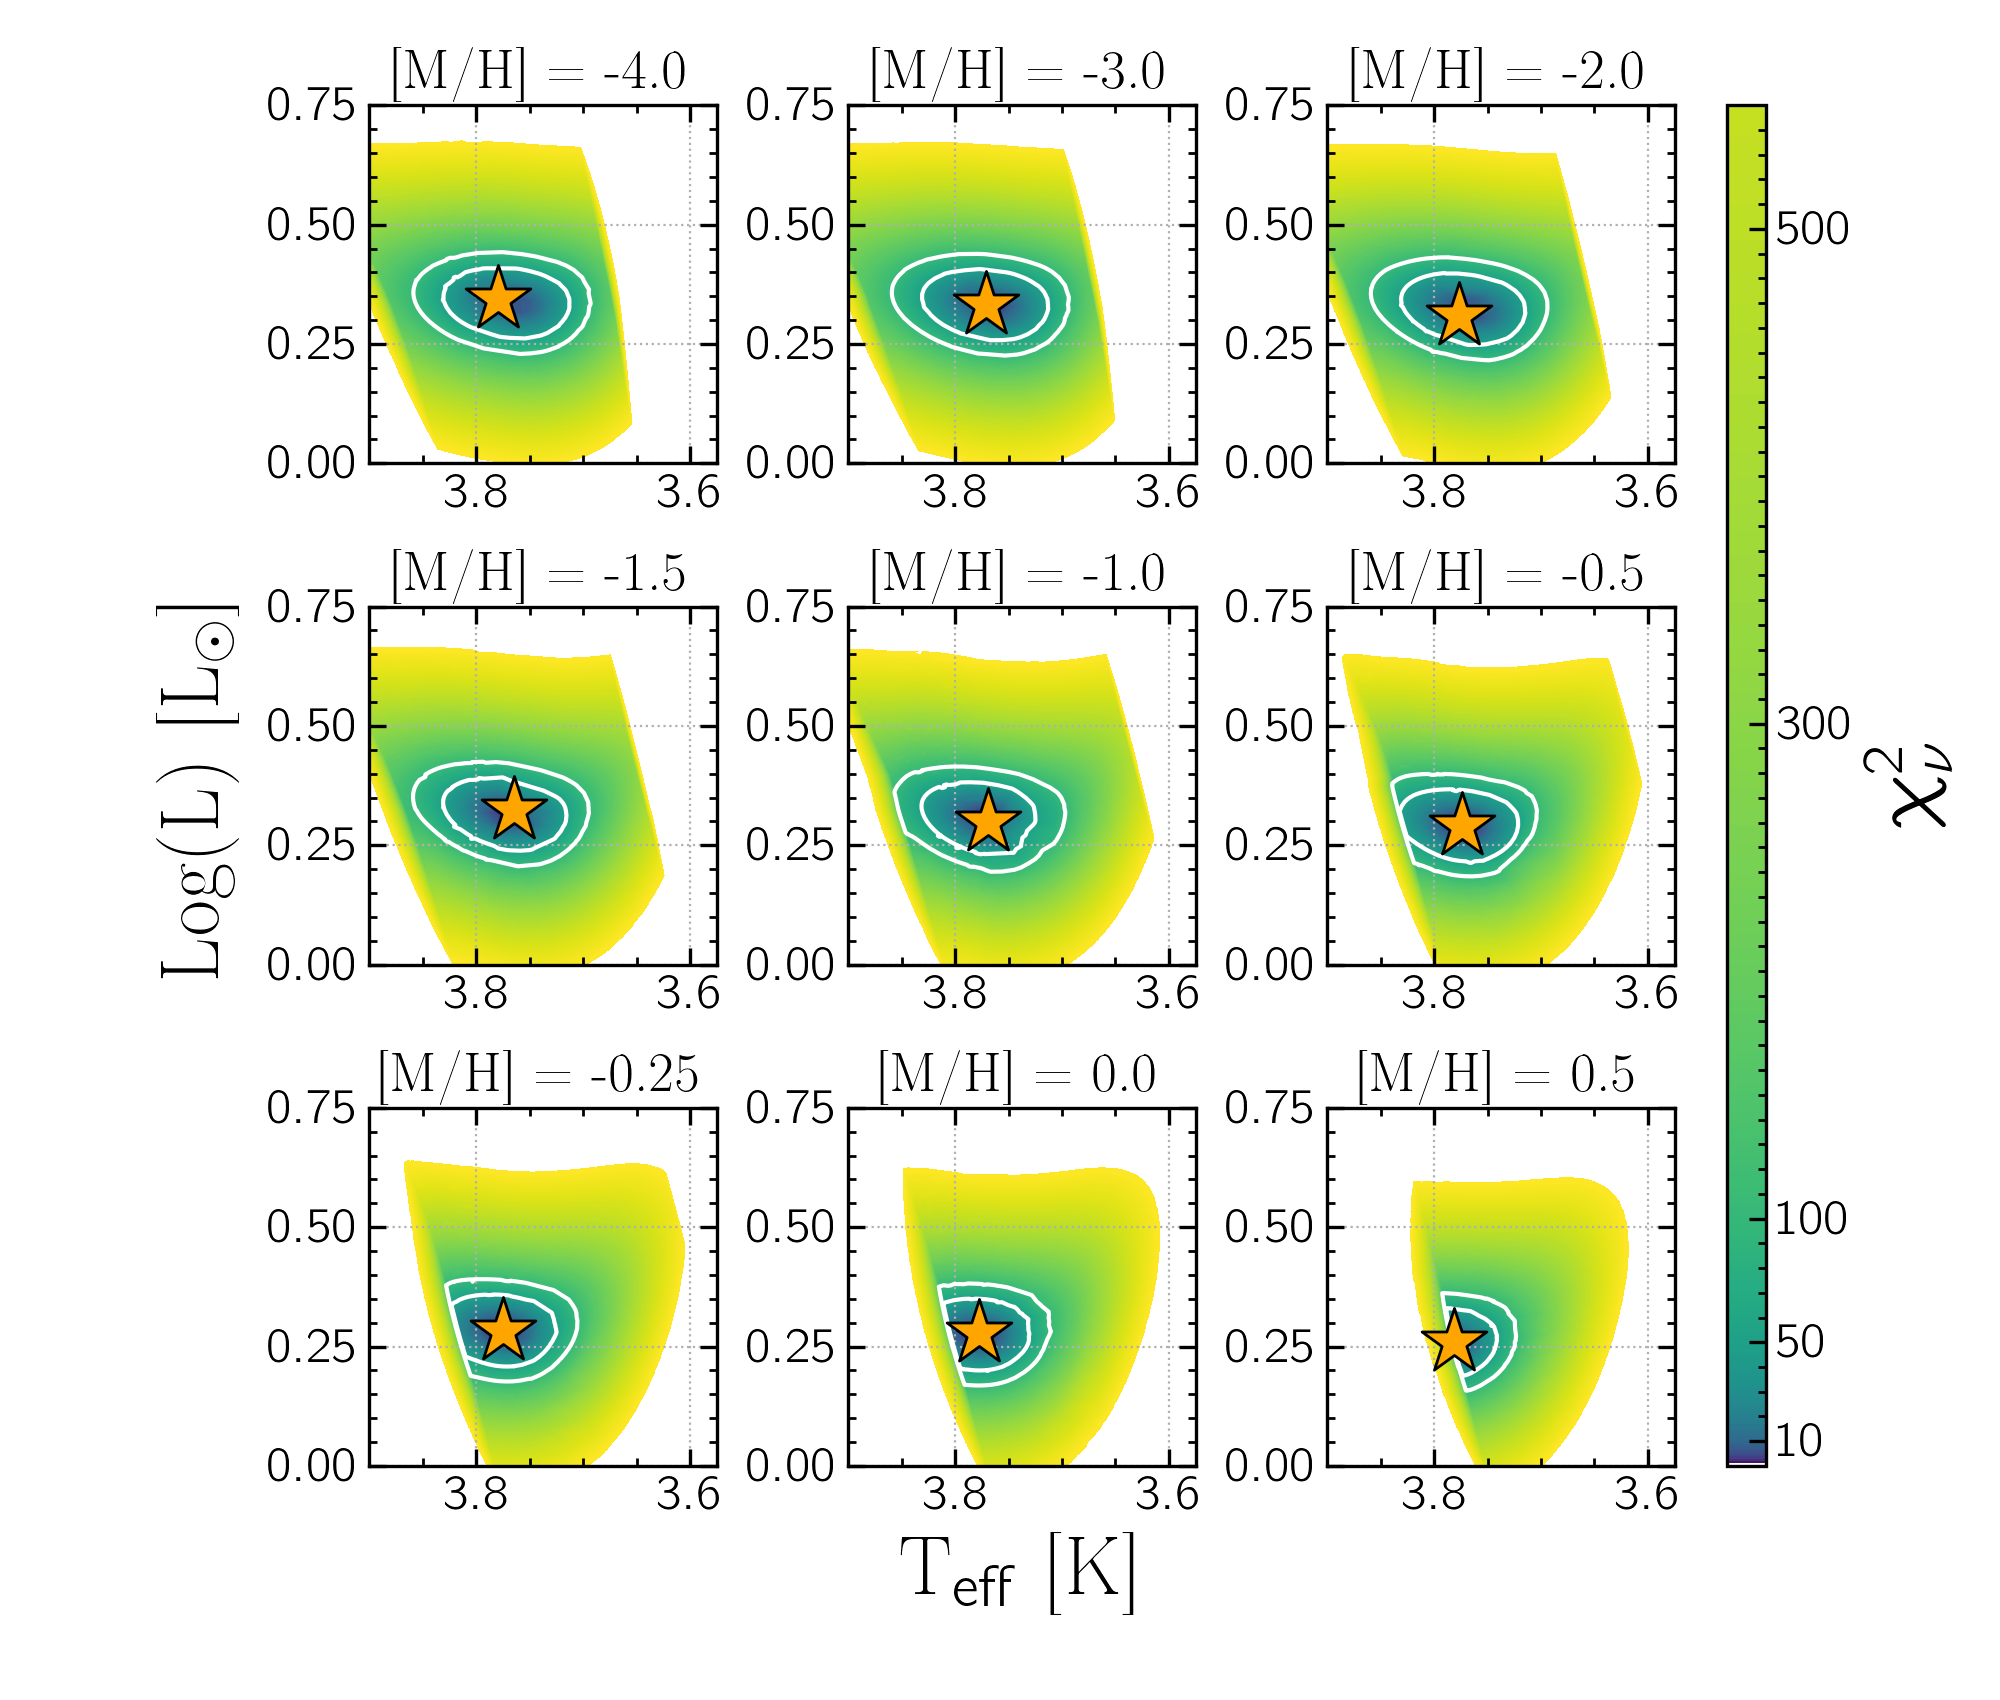

In [97]:
mhs = [-4.00,-3.00,-2.00,-1.50,-1.00,-0.50,-0.25,0.00,0.50]
mhs_strings = []
for i in range(len(mhs)):
    string = str(mhs[i])
    if '-' in string:
        string = string.replace('-','m')
    else:
        string = 'p'+string
    string += '0'
    mhs_strings.append(string)
mhs_strings[6] = mhs_strings[6].replace('m0.250','m0.25')

teffs_at_chimin = []
lums_at_chimin = []

import matplotlib
from matplotlib.ticker import LogLocator, LogFormatter
l_f = LogFormatter(10)
plt.style.use('magrathea')

import matplotlib.gridspec as gridspec

%matplotlib notebook
fig = plt.figure(figsize=(10,8.5))
gs = gridspec.GridSpec(nrows=3, ncols=3)

ax1 = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('T$_{\mathrm{eff}}$ [K]', fontsize=30)
plt.ylabel('Log(L) [L$_{\odot}$]',fontsize=30)
plt.gca().yaxis.set_label_coords(-0.1, 0.5)

row = [0,0,0,1,1,1,2,2,2]
column = [0,1,2,0,1,2,0,1,2]

for i in range(len(mhs)):

    ax0 = fig.add_subplot(gs[row[i],column[i]])
    string = mhs_strings[i]
    file = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output-A.csv'
    mist = pd.read_csv(file)
    ind = np.argsort(mist['chi2'])
    
    levels = np.linspace(0,1000,1000)
    im = ax0.tricontourf(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, cmap = 'viridis', 
                    norm=matplotlib.colors.LogNorm())
    levels = [50,100]
    CS = ax0.tricontour(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, 
                   colors=['w']*len(levels))
    ax0.clabel(CS, CS.levels, inline=True, fontsize=25, inline_spacing=0.5, use_clabeltext=True)

    ax0.scatter(mist['log_Teff'][ind[0]], mist['log_L'][ind[0]], color='orange', marker = '*',s=600, zorder=10, 
                edgecolors = 'black')
    ax0.set_title('[M/H] = '+str(mhs[i]))
    
    teffs_at_chimin.append(mist['log_Teff'][ind[0]])
    lums_at_chimin.append(mist['log_L'][ind[0]])

    #if i in range(2):
    #    ax0.set_xlim(3.575,3.725)
    #elif i in range(2,5):
    #    ax0.set_xlim(3.525,3.675)
    #else:
    #    ax0.set_xlim(3.475,3.625)
    ax0.set_xlim(3.575,3.9)

    ax0.grid(ls=':')
    ax0.set_ylim(0.0,0.75)
    ax0.invert_xaxis()

    
cbarticks = [10, 50, 100, 300, 500]
cax = ax1.inset_axes([1.04, 0., 0.03, 1.0], transform=ax1.transAxes)
#cbar = fig.colorbar(x, ax=axes[1], cax=cax)
cbar = fig.colorbar(im, ax=ax1, cax=cax, ticks=cbarticks)
cbar.ax.set_ylim(top = 550)
cbar.set_label(r'$\chi_\nu^2$',fontsize=30)


plt.tight_layout()
plt.savefig('MIST_models_chi2MAP_A_primaryas_M0V-all-metalicities-vcrit0.0.png',
             dpi=300,
           bbox_inches = 'tight')
plt.savefig(
    'MIST_models_chi2MAP_A_primaryas_M0V_transparent-all-metalicities-vcrit0.0.png',
            dpi=300,transparent=True, bbox_inches = 'tight')

In [100]:
mhs = [-4.00,-3.00,-2.00,-1.50,-1.00,-0.50,-0.25,0.00,0.50]
mhs_strings = []
for i in range(len(mhs)):
    string = str(mhs[i])
    if '-' in string:
        string = string.replace('-','m')
    else:
        string = 'p'+string
    string += '0'
    mhs_strings.append(string)
mhs_strings[6] = mhs_strings[6].replace('m0.250','m0.25')

mh_chi2s = []

for i in range(len(mhs_strings)):
    string = mhs_strings[i]
    file = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output-A.csv'
    mist = pd.read_csv(file)
    print(string,np.min(mist['chi2'])/5)
    mh_chi2s.append(np.min(mist['chi2'])/5)

m4.00 3.4789791483688433
m3.00 1.664056911630102
m2.00 4.400273643945484
m1.50 2.4828531966913987
m1.00 0.5008523711991304
m0.50 0.26210414005969795
m0.25 0.28472461272119765
p0.00 0.6652934847766814
p0.50 3.7224762485448366


In [99]:
i=5
string = mhs_strings[i]
file = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output-A.csv'
mist = pd.read_csv(file)

ind = np.where((mist['log_Teff'] > 3.475) & (mist['log_Teff'] < 3.625))[0]
ind2 = np.where((mist['log_L'] > -1.75) & (mist['log_L'] < 0))[0]
ind3 = np.where((mist['log_Teff'] > 3.475) & (mist['log_Teff'] < 3.625) & (mist['log_L'] > -1.75)
                & (mist['log_L'] < 0))[0]
teff_array = mist['log_Teff'][ind3]
teff_array = teff_array.reset_index(drop=True)
lum_array = mist['log_L'][ind3]
lum_array = lum_array.reset_index(drop=True)
chi_array = mist['chi2'][ind3]
ind4 = np.argsort(chi_array)
ind4 = ind4.reset_index(drop=True)

teff_chimin = teff_array[ind4[0]]
lum_chimin = lum_array[ind4[0]]
10**teff_chimin,lum_chimin

(4210.773224055356, -0.0166594206213986)

m4.00 3.4789791483688433
m3.00 1.664056911630102
m2.00 4.400273643945484
m1.50 2.4828531966913987
m1.00 0.5008523711991304
m0.50 0.26210414005969795
m0.25 0.28472461272119765
p0.00 0.6652934847766814
p0.50 3.7224762485448366


<IPython.core.display.Javascript object>


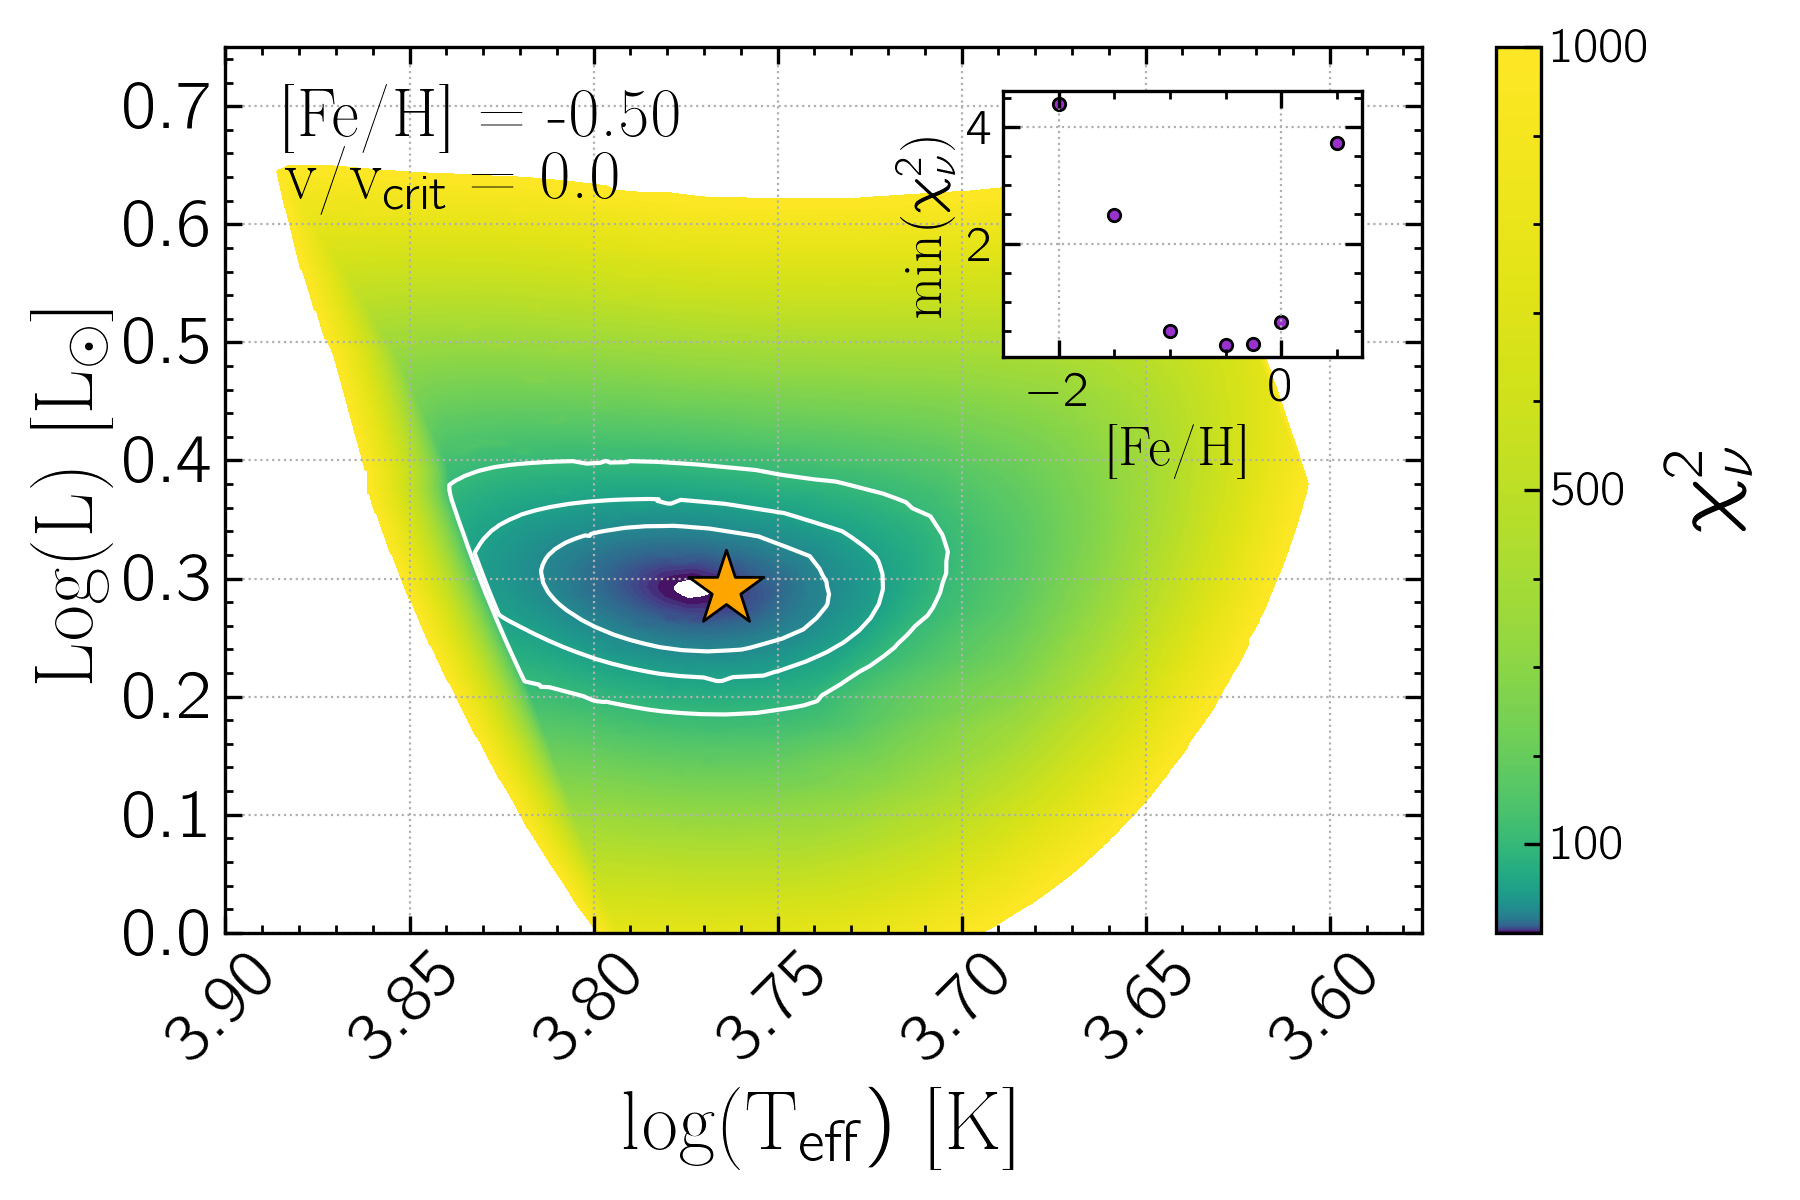

In [115]:
mhs = [-4.00,-3.00,-2.00,-1.50,-1.00,-0.50,-0.25, 0.00,0.50]
mhs_strings = []
for i in range(len(mhs)):
    string = str(mhs[i])
    if '-' in string:
        string = string.replace('-','m')
    else:
        string = 'p'+string
    string += '0'
    mhs_strings.append(string)
mhs_strings[6] = mhs_strings[6].replace('m0.250','m0.25')

mh_chi2s = []

for i in range(len(mhs_strings)):
    string = mhs_strings[i]
    file = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output-A.csv'
    mist = pd.read_csv(file)
    print(string,np.min(mist['chi2'])/5)
    mh_chi2s.append(np.min(mist['chi2'])/5)



i=5
string = mhs_strings[i]
file = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output-A.csv'
mist = pd.read_csv(file)
ind = np.argsort(mist['chi2'])

import matplotlib
from matplotlib.ticker import LogLocator, LogFormatter
l_f = LogFormatter(10)


plt.style.use('magrathea')
%matplotlib notebook
plt.figure(figsize = (9,6))
plt.grid(ls=':')
levels = np.linspace(0,1000,1000)
im = plt.tricontourf(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, cmap = 'viridis', 
                norm=matplotlib.colors.LogNorm())
cbarticks = [100,500,1000]
cbar = plt.colorbar(im,ticks=cbarticks)
#levels = [(mist['chi2'][ind[0]])/6+1,25, 50, 100]
clevels = [25, 50, 100]
CS = plt.tricontour(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = clevels, 
               colors=['w']*len(clevels))
#plt.clabel(CS, CS.levels, inline=True, fontsize=15, inline_spacing=0.5, use_clabeltext=True)

plt.scatter(mist['log_Teff'][ind[0]], mist['log_L'][ind[0]], color='orange', marker = '*',s=800, zorder=10, 
            edgecolors = 'black')

plt.annotate('[Fe/H] = '+string.replace('m','-'),xy = (0.05,0.9), xycoords = 'axes fraction', fontsize=25)
plt.annotate('v/v$_\mathrm{crit}$ = 0.0',xy = (0.05,0.83), xycoords = 'axes fraction', fontsize=25)

plt.xlim(3.575,3.9)
plt.ylim(0.0,0.75)
plt.gca().invert_xaxis()
cbar.set_label(r'$\chi_\nu^2$',fontsize=30)
plt.xlabel('log(T$_{\mathrm{eff}})$ [K]', fontsize=30)
plt.xticks(fontsize=25, rotation=45)
plt.ylabel('Log(L) [L$_{\odot}$]',fontsize=30)
plt.yticks(fontsize=25)

######################## inset axes #######
ax = plt.gca()
axins = ax.inset_axes([0.65, 0.65, 0.3, 0.3])
axins.scatter(mhs, mh_chi2s, marker="o", ls='None', s=20, color='darkorchid',edgecolor='black')
axins.grid(ls=':')
axins.set_xlabel('[Fe/H]')
axins.set_ylabel(r'min($\chi_\nu^2$)')
axins.set_xlim(left=-2.5)


plt.tight_layout()

#plt.savefig('best_best_final_plots/MIST_models_chi2MAP_A_primaryas_M0V-mh_p05_wchi2plot.png',
#           dpi=300,
#           bbox_inches = 'tight')

<IPython.core.display.Javascript object>


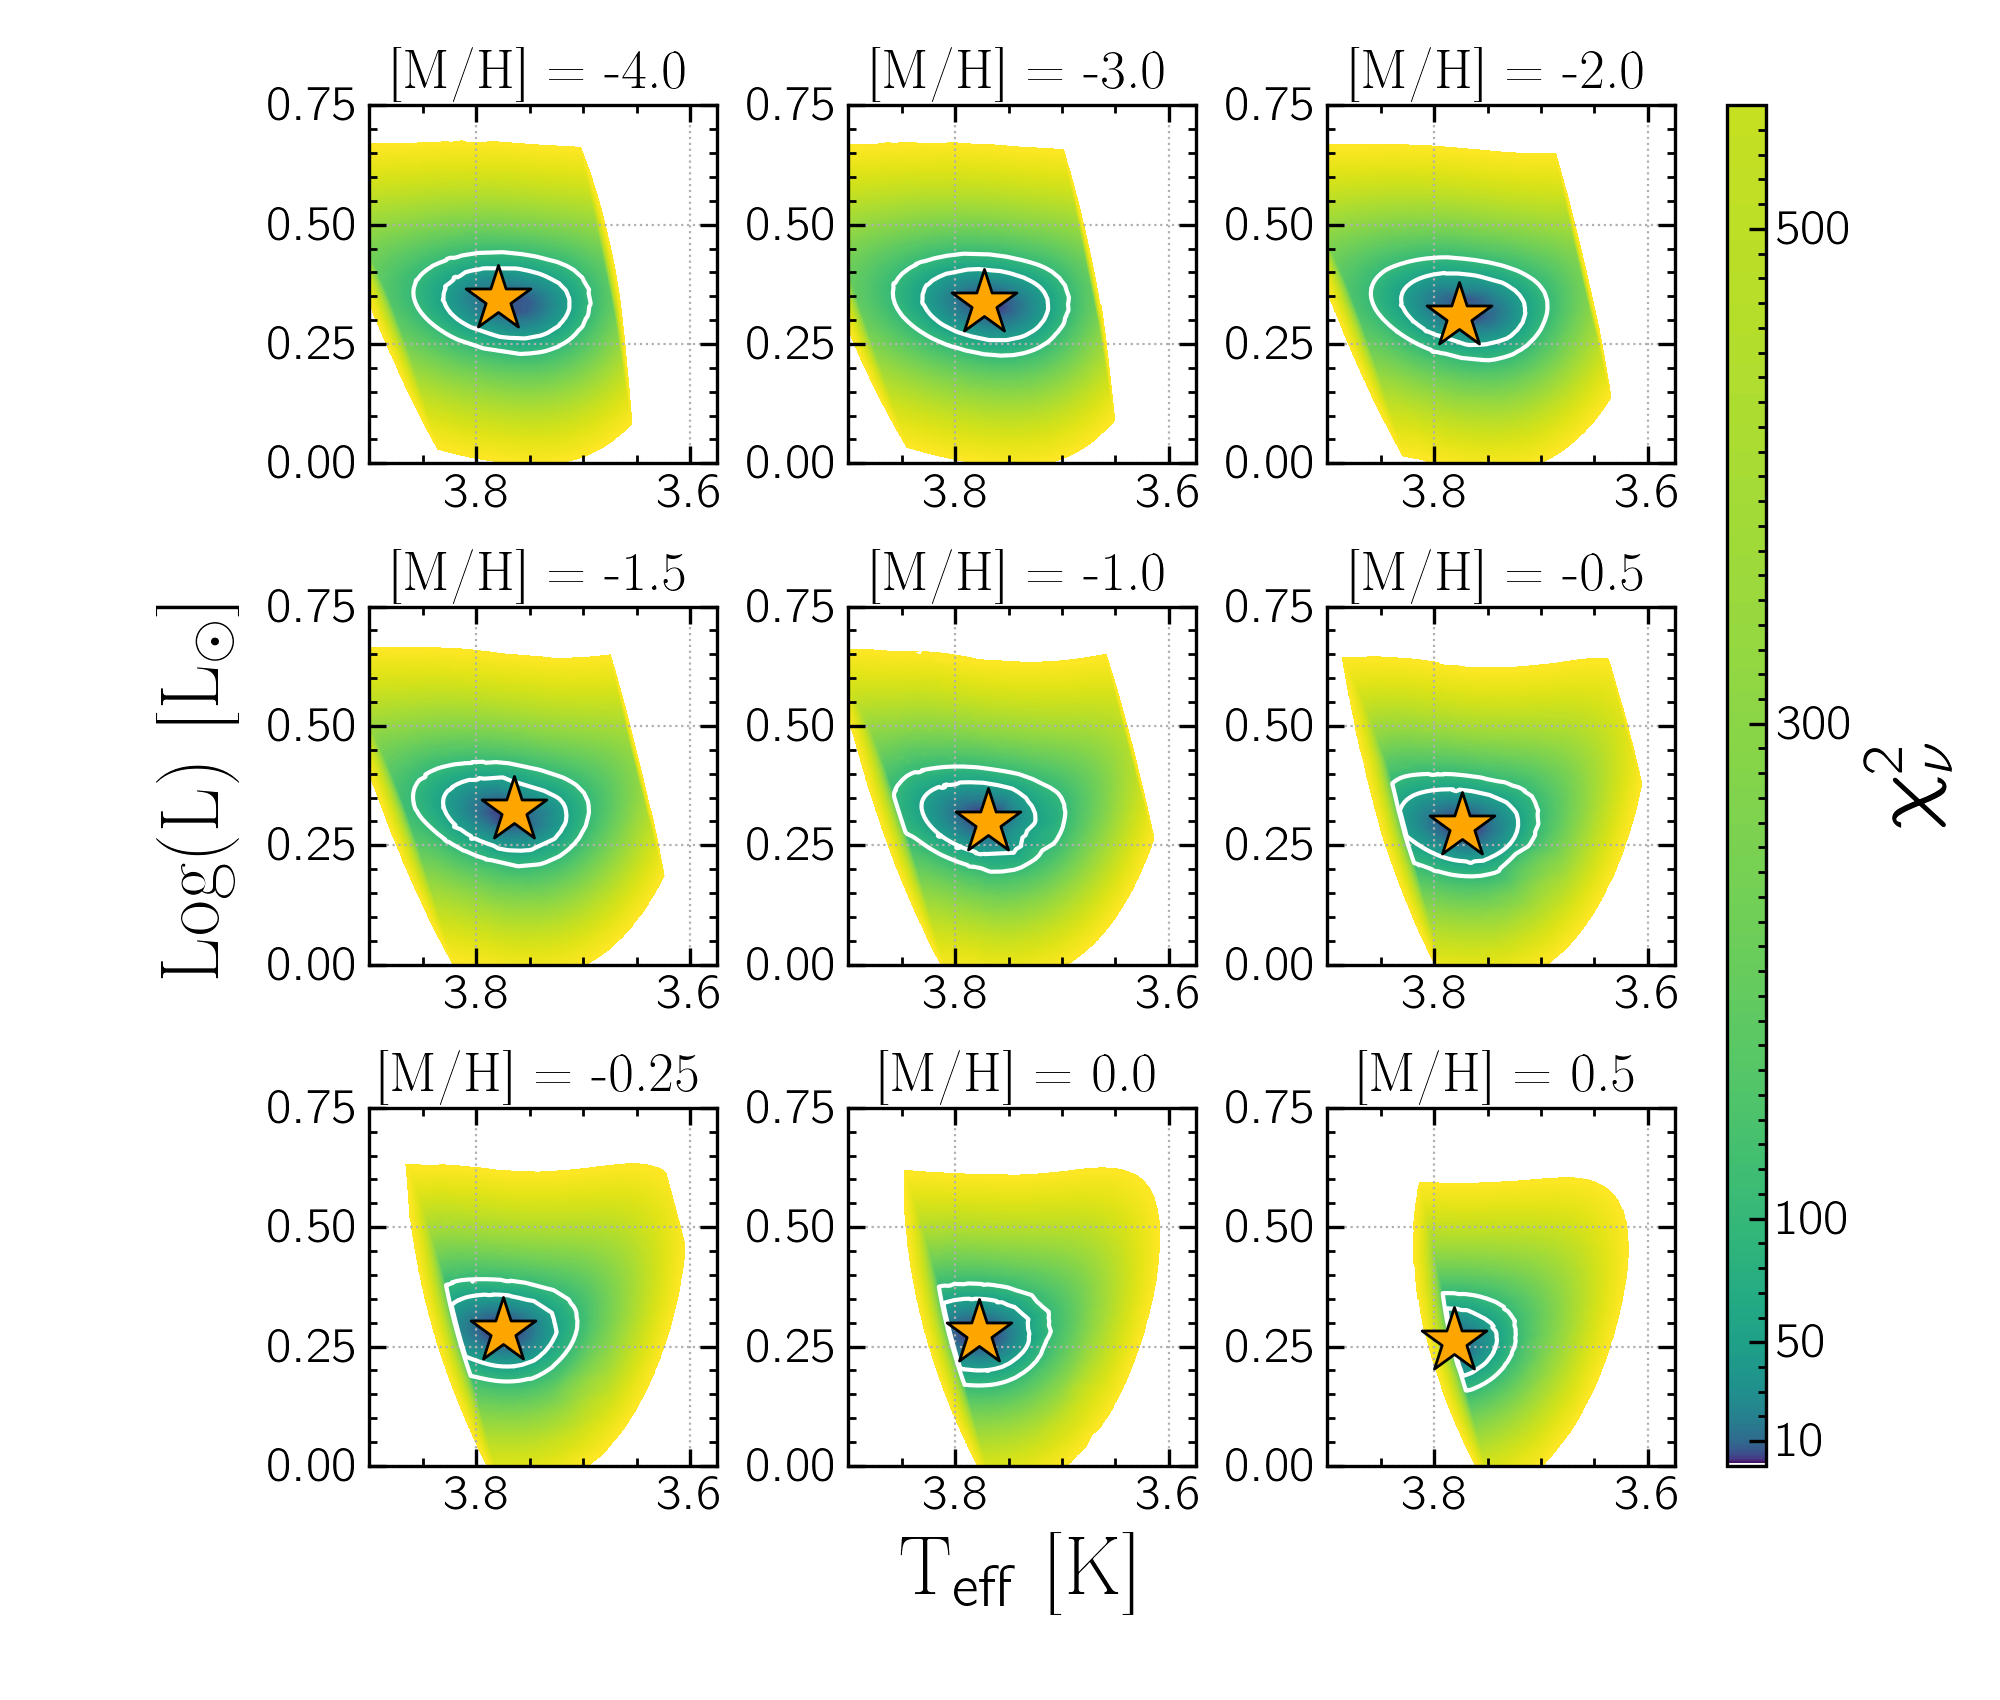

In [109]:
mhs = [-4.00,-3.00,-2.00,-1.50,-1.00,-0.50,-0.25,0.00,0.50]
mhs_strings = []
for i in range(len(mhs)):
    string = str(mhs[i])
    if '-' in string:
        string = string.replace('-','m')
    else:
        string = 'p'+string
    string += '0'
    mhs_strings.append(string)
mhs_strings[6] = mhs_strings[6].replace('m0.250','m0.25')

teffs_at_chimin = []
lums_at_chimin = []

import matplotlib
from matplotlib.ticker import LogLocator, LogFormatter
l_f = LogFormatter(10)
plt.style.use('magrathea')

import matplotlib.gridspec as gridspec

%matplotlib notebook
fig = plt.figure(figsize=(10,8.5))
gs = gridspec.GridSpec(nrows=3, ncols=3)

ax1 = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('T$_{\mathrm{eff}}$ [K]', fontsize=30)
plt.ylabel('Log(L) [L$_{\odot}$]',fontsize=30)
plt.gca().yaxis.set_label_coords(-0.1, 0.5)

row = [0,0,0,1,1,1,2,2,2]
column = [0,1,2,0,1,2,0,1,2]

for i in range(len(mhs)):

    ax0 = fig.add_subplot(gs[row[i],column[i]])
    string = mhs_strings[i]
    file = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd--chi2-output-A.csv'
    mist = pd.read_csv(file)
    ind = np.argsort(mist['chi2'])
    
    levels = np.linspace(0,1000,1000)
    im = ax0.tricontourf(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, cmap = 'viridis', 
                    norm=matplotlib.colors.LogNorm())
    levels = [50,100]
    CS = ax0.tricontour(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, 
                   colors=['w']*len(levels))
    ax0.clabel(CS, CS.levels, inline=True, fontsize=25, inline_spacing=0.5, use_clabeltext=True)

    ax0.scatter(mist['log_Teff'][ind[0]], mist['log_L'][ind[0]], color='orange', marker = '*',s=600, zorder=10, 
                edgecolors = 'black')
    ax0.set_title('[M/H] = '+str(mhs[i]))
    
    teffs_at_chimin.append(mist['log_Teff'][ind[0]])
    lums_at_chimin.append(mist['log_L'][ind[0]])

    #if i in range(2):
    #    ax0.set_xlim(3.575,3.725)
    #elif i in range(2,5):
    #    ax0.set_xlim(3.525,3.675)
    #else:
    #    ax0.set_xlim(3.475,3.625)
    ax0.set_xlim(3.575,3.9)

    ax0.grid(ls=':')
    ax0.set_ylim(0.0,0.75)
    ax0.invert_xaxis()

    
cbarticks = [10, 50, 100, 300, 500]
cax = ax1.inset_axes([1.04, 0., 0.03, 1.0], transform=ax1.transAxes)
#cbar = fig.colorbar(x, ax=axes[1], cax=cax)
cbar = fig.colorbar(im, ax=ax1, cax=cax, ticks=cbarticks)
cbar.ax.set_ylim(top = 550)
cbar.set_label(r'$\chi_\nu^2$',fontsize=30)


plt.tight_layout()
plt.savefig('MIST_models_chi2MAP_A_primaryas_M0V-all-metalicities-vcrit0.4.png',
             dpi=300,
           bbox_inches = 'tight')
plt.savefig(
    'MIST_models_chi2MAP_A_primaryas_M0V_transparent-all-metalicities-vcrit0.4.png',
            dpi=300,transparent=True, bbox_inches = 'tight')

In [110]:
mhs = [-4.00,-3.00,-2.00,-1.50,-1.00,-0.50,-0.25, 0.00,0.50]
mhs_strings = []
for i in range(len(mhs)):
    string = str(mhs[i])
    if '-' in string:
        string = string.replace('-','m')
    else:
        string = 'p'+string
    string += '0'
    mhs_strings.append(string)
mhs_strings[6] = mhs_strings[6].replace('m0.250','m0.25')

mh_chi2s = []

for i in range(len(mhs_strings)):
    string = mhs_strings[i]
    file = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd--chi2-output-A.csv'
    mist = pd.read_csv(file)
    print(string,np.min(mist['chi2'])/5)
    mh_chi2s.append(np.min(mist['chi2'])/5)

m4.00 3.4789791483688433
m3.00 1.9063577652563235
m2.00 4.400273643945484
m1.50 2.4828531966913987
m1.00 0.5008523711991304
m0.50 0.26210414005969795
m0.25 0.28472461272119765
p0.00 0.6652934847766814
p0.50 3.75541263035901


<IPython.core.display.Javascript object>


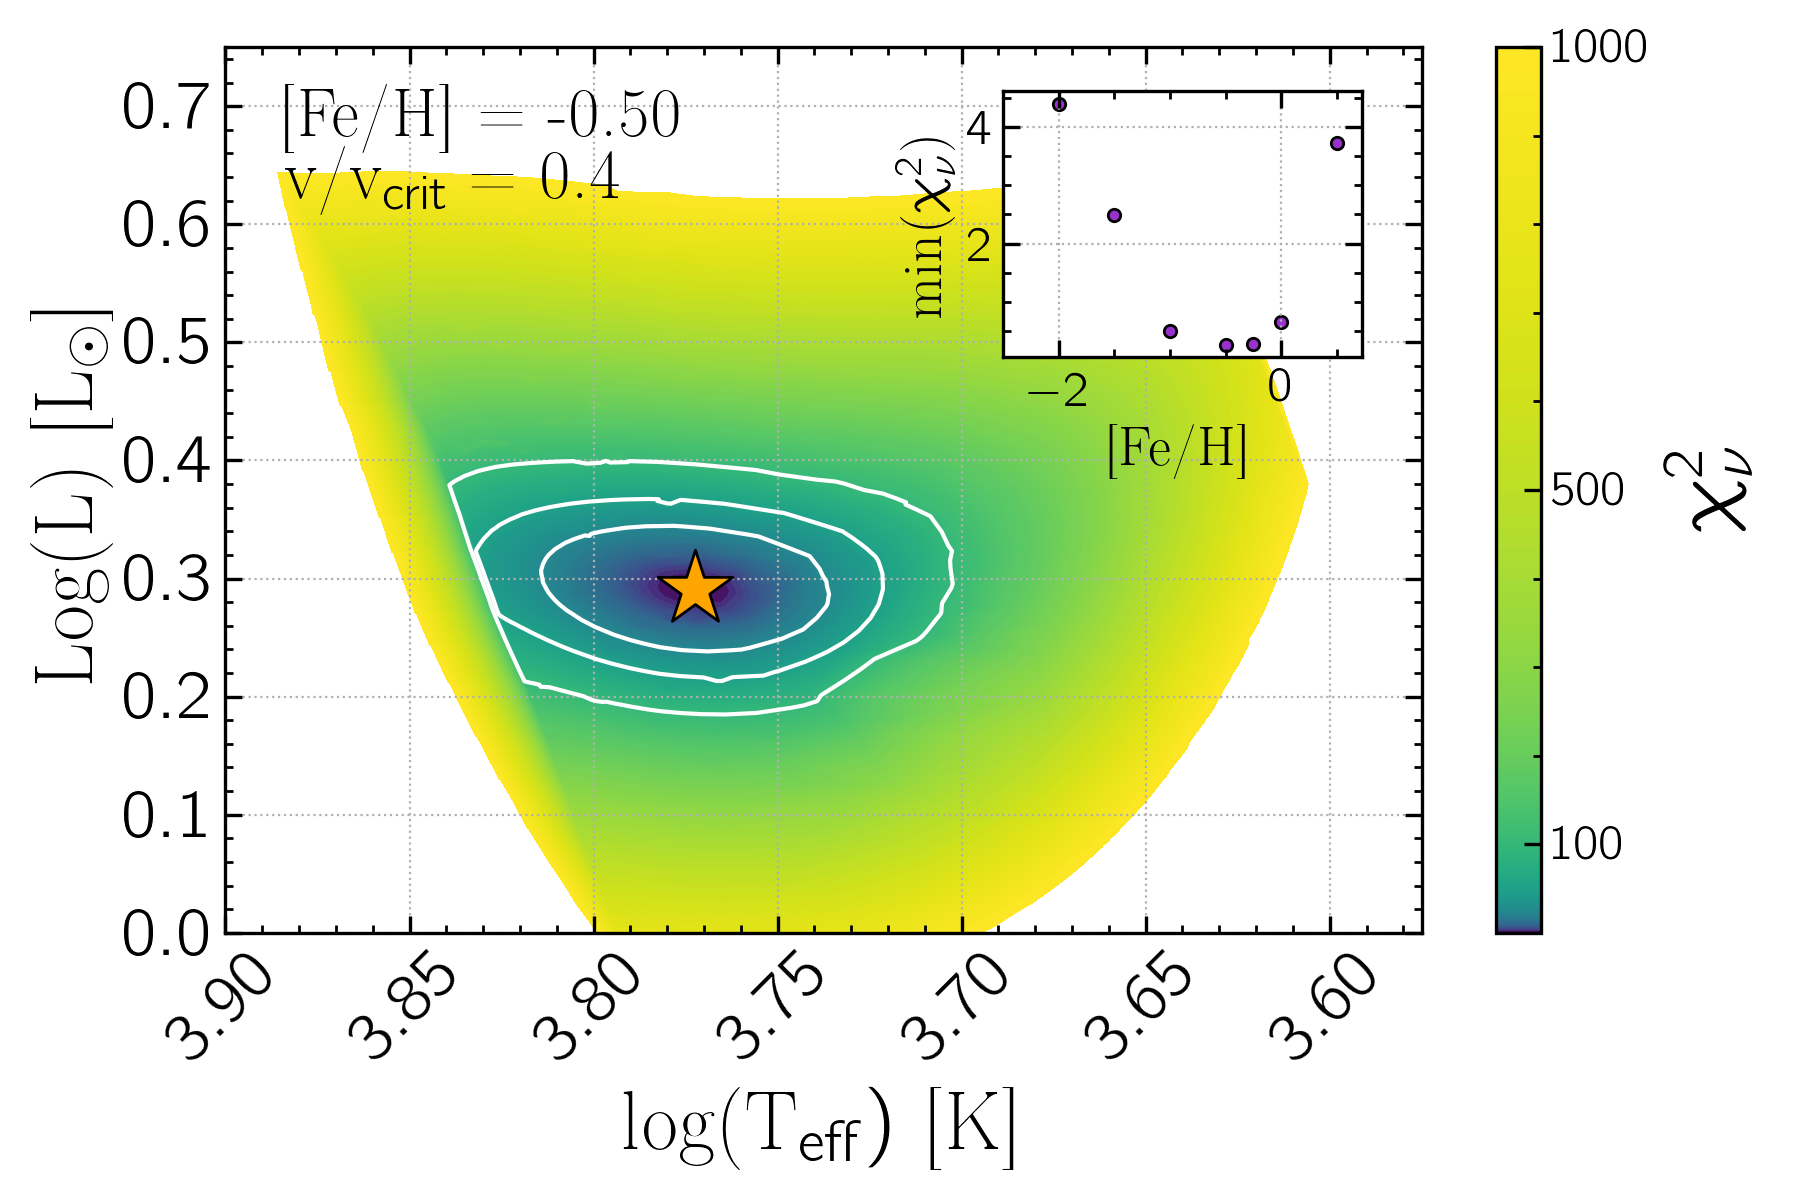

In [118]:
i=5
string = mhs_strings[i]
file = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd--chi2-output-A.csv'
mist = pd.read_csv(file)
ind = np.argsort(mist['chi2'])

import matplotlib
from matplotlib.ticker import LogLocator, LogFormatter
l_f = LogFormatter(10)


plt.style.use('magrathea')
%matplotlib notebook
plt.figure(figsize = (9,6))
plt.grid(ls=':')
levels = np.linspace(0,1000,1000)
im = plt.tricontourf(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = levels, cmap = 'viridis', 
                norm=matplotlib.colors.LogNorm())
cbarticks = [100,500,1000]
cbar = plt.colorbar(im,ticks=cbarticks)
#levels = [(mist['chi2'][ind[0]])/6+1,25, 50, 100]
clevels = [25, 50, 100]
CS = plt.tricontour(mist['log_Teff'], mist['log_L'], mist['chi2']/5, levels = clevels, 
               colors=['w']*len(clevels))
#plt.clabel(CS, CS.levels, inline=True, fontsize=15, inline_spacing=0.5, use_clabeltext=True)

plt.scatter(mist['log_Teff'][ind[0]]-0.0015, mist['log_L'][ind[0]], color='orange', marker = '*',s=800, zorder=10, 
            edgecolors = 'black')

plt.annotate('[Fe/H] = '+string.replace('m','-'),xy = (0.05,0.9), xycoords = 'axes fraction', fontsize=25)
plt.annotate('v/v$_\mathrm{crit}$ = 0.4',xy = (0.05,0.83), xycoords = 'axes fraction', fontsize=25)

plt.xlim(3.575,3.9)
plt.ylim(0.0,0.75)
plt.gca().invert_xaxis()
cbar.set_label(r'$\chi_\nu^2$',fontsize=30)
plt.xlabel('log(T$_{\mathrm{eff}})$ [K]', fontsize=30)
plt.xticks(fontsize=25, rotation=45)
plt.ylabel('Log(L) [L$_{\odot}$]',fontsize=30)
plt.yticks(fontsize=25)

######################## inset axes #######
ax = plt.gca()
axins = ax.inset_axes([0.65, 0.65, 0.3, 0.3])
axins.scatter(mhs, mh_chi2s, marker="o", ls='None', s=20, color='darkorchid',edgecolor='black')
axins.grid(ls=':')
axins.set_xlabel('[Fe/H]')
axins.set_ylabel(r'min($\chi_\nu^2$)')
axins.set_xlim(left=-2.5)


plt.tight_layout()

plt.savefig('best_best_final_plots/MIST_models_chi2MAP_A_primaryas_M0V-mh_m05_wchi2plot.png',
           dpi=300,
           bbox_inches = 'tight')

In [251]:
i=5
string = mhs_strings[i]
file = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd--chi2-output-A.csv'
mist = pd.read_csv(file)

#ind = np.where((mist['log_Teff'] > 3.475) & (mist['log_Teff'] < 3.625))[0]
#ind2 = np.where((mist['log_L'] > -1.75) & (mist['log_L'] < 0))[0]
ind3 = np.where((mist['log_Teff'] > 3.575) & (mist['log_Teff'] < 3.9) & (mist['log_L'] > 0.0)
                & (mist['log_L'] < 0.75))[0]
teff_array = mist['log_Teff'][ind3]
teff_array = teff_array.reset_index(drop=True)
lum_array = mist['log_L'][ind3]
lum_array = lum_array.reset_index(drop=True)
age_array = mist['log10_isochrone_age_yr'][ind3]
age_array = age_array.reset_index(drop=True)
chi_array = mist['chi2'][ind3]
ind4 = np.argsort(chi_array)
ind4 = ind4.reset_index(drop=True)

A_teff_chimin = teff_array[ind4[0]]
A_lum_chimin = lum_array[ind4[0]]
A_age_chimin = age_array[ind4[0]]
10**A_teff_chimin,A_teff_chimin,A_lum_chimin,(10**A_age_chimin)/1e9

(5941.416605965196, 3.7738900057226497, 0.2913332304220994, 12.589254117941662)

In [248]:
mist.loc[np.where(mist['chi2'] == np.min(mist['chi2']))[0]]

EEP  log10_isochrone_age_yr  initial_mass  star_mass  log_Teff  \
97134  445                    10.1      0.842703   0.842171   3.77389   

          log_g     log_L  [Fe/H]_init   [Fe/H]    SDSS_u    SDSS_g    SDSS_r  \
97134  4.121913  0.291333         -0.5 -0.64581  5.342858  4.324094  3.959169   

         SDSS_i    SDSS_z  phase       g-r       r-i      chi2  
97134  3.864933  3.855003    0.0  0.364925  0.094236  1.310521

In [9]:
import matplotlib
ind = np.argsort(mist['chi2'])


SDSS_filters = {'z':0.8931,'i':0.7481,'r':0.6165,'g':.4686}
f = [SDSS_filters['g'],SDSS_filters['r'],SDSS_filters['i'],SDSS_filters['z']]

AM = [np.mean(A_Mg),np.mean(A_Mr),np.mean(A_Mi),np.mean(A_Mz)]
eAM = [np.std(A_Mg),np.std(A_Mr),np.std(A_Mi),np.std(A_Mz)]
AMIST = ['SDSS_g','SDSS_r','SDSS_i','SDSS_z']
print(eAM)

Acolorlist = [np.mean(ARminusI),np.mean(AGminusR)]
eAcolorlist = [np.std(ARminusI),np.std(AGminusR)]
Acolormist = ['r-i','g-r']

CM = [np.mean(C_Mg),np.mean(C_Mr),np.mean(C_Mi),np.mean(C_Mz)]
eCM = [np.std(C_Mg),np.std(C_Mr),np.std(C_Mi),np.std(C_Mz)]
CMIST = ['SDSS_g','SDSS_r','SDSS_i','SDSS_z']
print(eCM)

colorlist = [np.mean(CRminusI),np.mean(CGminusR)]
ecolorlist = [np.std(CRminusI),np.std(CGminusR)]
colormist = ['r-i','g-r']

%matplotlib notebook
N = 8
cmap = matplotlib.cm.get_cmap('Set1')
colors = cmap(np.linspace(0,1,N))

###### A
i=5
string = mhs_strings[i]
file = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd--chi2-output-A.csv'
Amist = pd.read_csv(file)

for i in range(4):
    for j in range(5):
        plt.scatter(f[i],Amist[AMIST[i]].loc[ind[j]], color=colors[j], marker='^', s=300, alpha = 0.5)

color = 'orangered'
for i in range(4):
    plt.scatter(f[i],AM[i], zorder=10, color=color)
    plt.errorbar(f[i],AM[i],yerr = eAM[i], ls='None', capsize = 3, 
                 zorder=10, color=color)
    
######### C
i=7
string = mhs_strings[i]
file = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd--chi2-output-C.csv'
Cmist = pd.read_csv(file)
print(file)

for i in range(4):
    for j in range(5):
        plt.scatter(f[i],Cmist[CMIST[i]].loc[ind[j]], color=colors[j], marker='D', s=300, alpha = 0.5)

color = 'orangered'
for i in range(4):
    plt.scatter(f[i],CM[i], zorder=10, color=color)
    plt.errorbar(f[i],CM[i],yerr = eCM[i], ls='None', capsize = 3, 
                 zorder=10, color=color)
    
    
plt.gca().invert_yaxis()

[0.0241722850662798, 0.02362572750697532, 0.02313767440226445, 0.024875811643472176]
[0.12423887106051286, 0.05833338583474528, 0.04084593930452262, 0.03537737242328832]


NameError: name 'mhs_strings' is not defined

# CMD

In [128]:
rminusiplot_hip,gminusrplot_hip,Mgplot_hip,Mrplot_hip,teffplot_hip,sptypeplot_hip = pickle.load(
            open('carmenes-hip-landolt-colors.pkl','rb'))

<IPython.core.display.Javascript object>


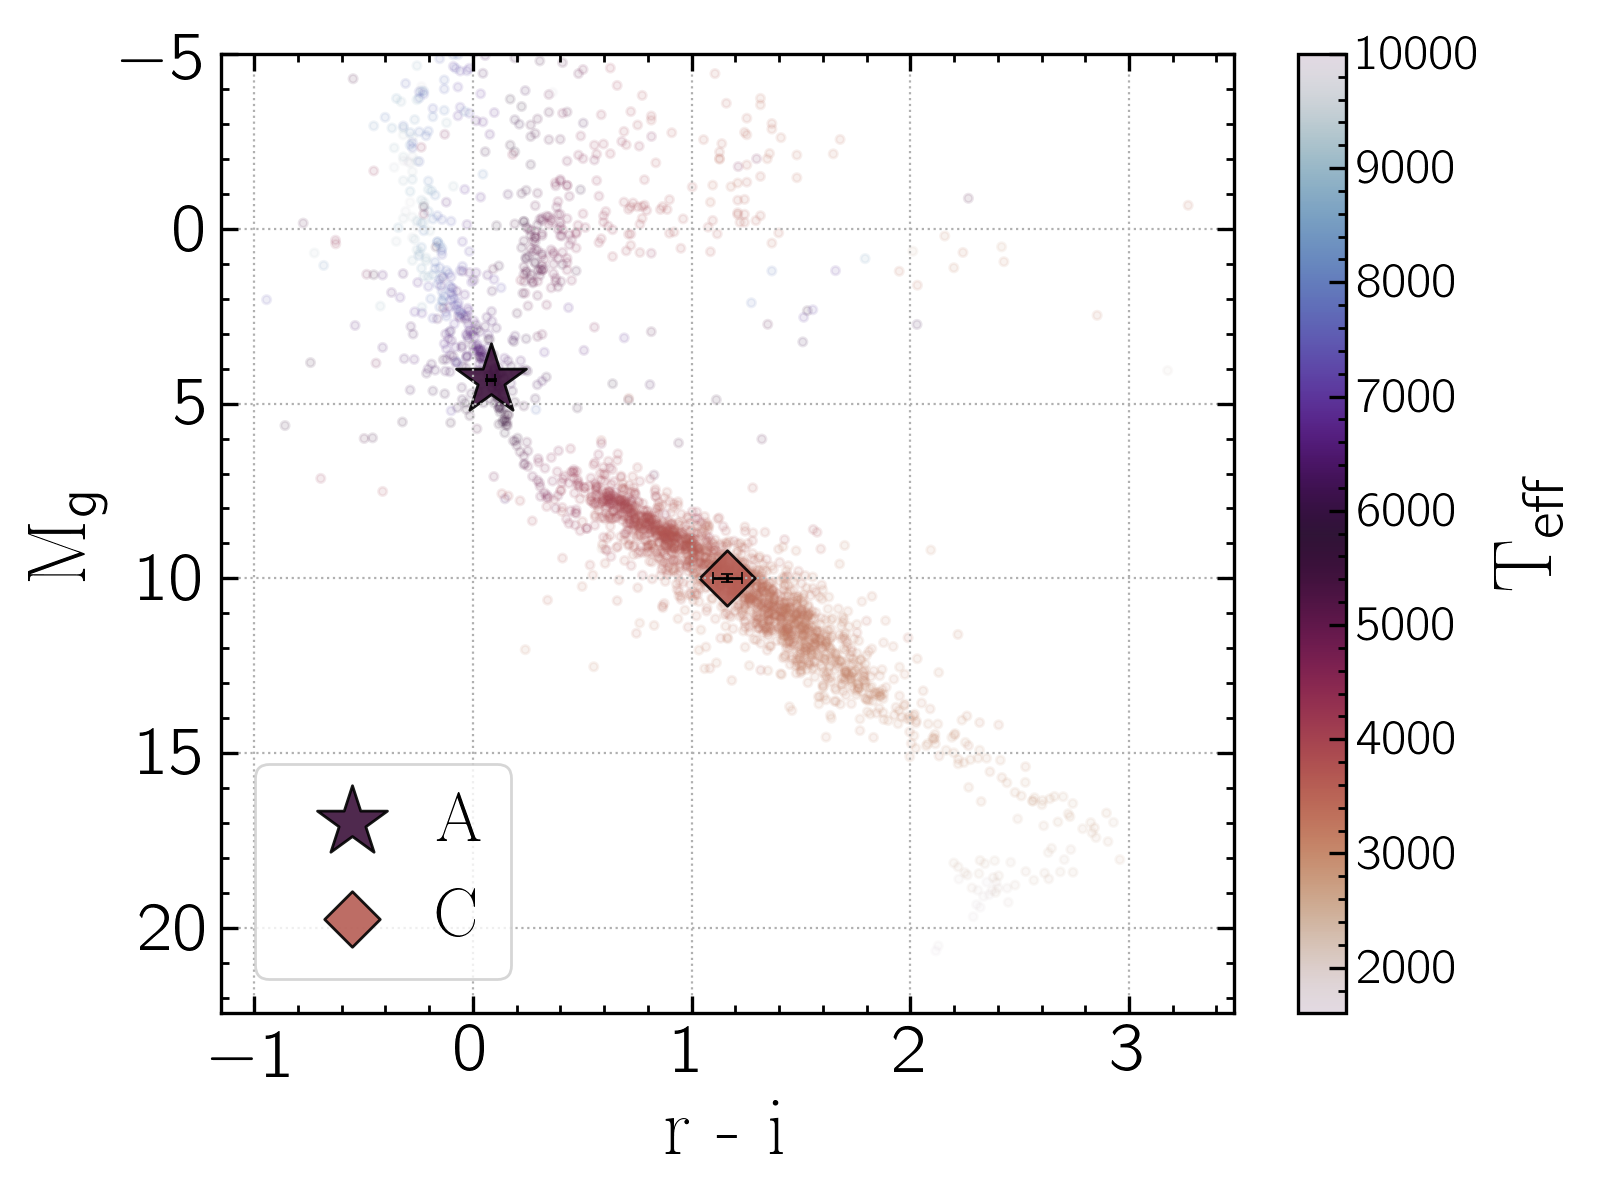

In [135]:
cmap = 'twilight_r'
#cmap = 'viridis'
#cmap = 'magma'
#cmap = 'turbo_r'
#cmap = 'gist_earth_r'
#Ccolor = 'orange'
#Acolor = 'darkred'
#Ccolor = 'midnightblue'
#Ccolor = 'purple'
#Acolor = 'darkorange'
#Acolor = 'orange'
#Acolor = 'purple'

import matplotlib

cmap = matplotlib.cm.get_cmap(cmap)
percent = (10**C_teff_chimin - np.nanmin(teffplot_hip)) / np.nanmax(teffplot_hip)
Ccolor = cmap(percent)
percent = (10**A_teff_chimin - np.nanmin(teffplot_hip)) / np.nanmax(teffplot_hip)
Acolor = cmap(percent)


%matplotlib notebook
plt.scatter(rminusiplot_hip,Mgplot_hip, 
         marker='.',ls='None',alpha=0.1, c = teffplot_hip, cmap = cmap)
cbar = plt.colorbar()
cbar.set_label(r'T$_{\mathrm{eff}}$',fontsize=30)
cbar.set_alpha(1)
cbar.draw_all()

plt.scatter(np.mean(ARminusI),np.nanmean(A_Mg),
           marker = '*', color=Acolor,s=700, label='A',alpha=0.9, edgecolor='black')
plt.errorbar(np.mean(ARminusI),np.nanmean(A_Mg), xerr = np.std(ARminusI), yerr = np.nanstd(A_Mg),
           ls='None', color='black',capsize = 2, lw=1)

plt.scatter(np.mean(CRminusI),np.nanmean(C_Mg),
           marker = 'D', color=Ccolor,s=200, label='C',alpha=0.9, edgecolor='black')
plt.errorbar(np.mean(CRminusI),np.nanmean(C_Mg), xerr = np.std(CRminusI), yerr = np.nanstd(C_Mg),
           ls='None', color='black',capsize = 2, lw=1)

#plt.xlim(-0.5,3.5)

plt.xlabel('r - i',fontsize = 30)
plt.ylabel('M$_\mathrm{g}$',fontsize = 30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.gca().invert_yaxis()
plt.ylim(top = -5)
plt.grid(ls=':')
plt.legend(fontsize=25)
#plt.title('CARMENES Sample CMD')
plt.tight_layout()
plt.savefig("best_best_final_plots/CARMENES_HIP_cmd_teff_primaryas_K7V.png", dpi=300)
plt.savefig("best_best_final_plots/CARMENES_HIP_cmd_teff_primaryas_K7V_transparent.png", dpi=300, transparent=True)

# Ev track:

## A

<IPython.core.display.Javascript object>


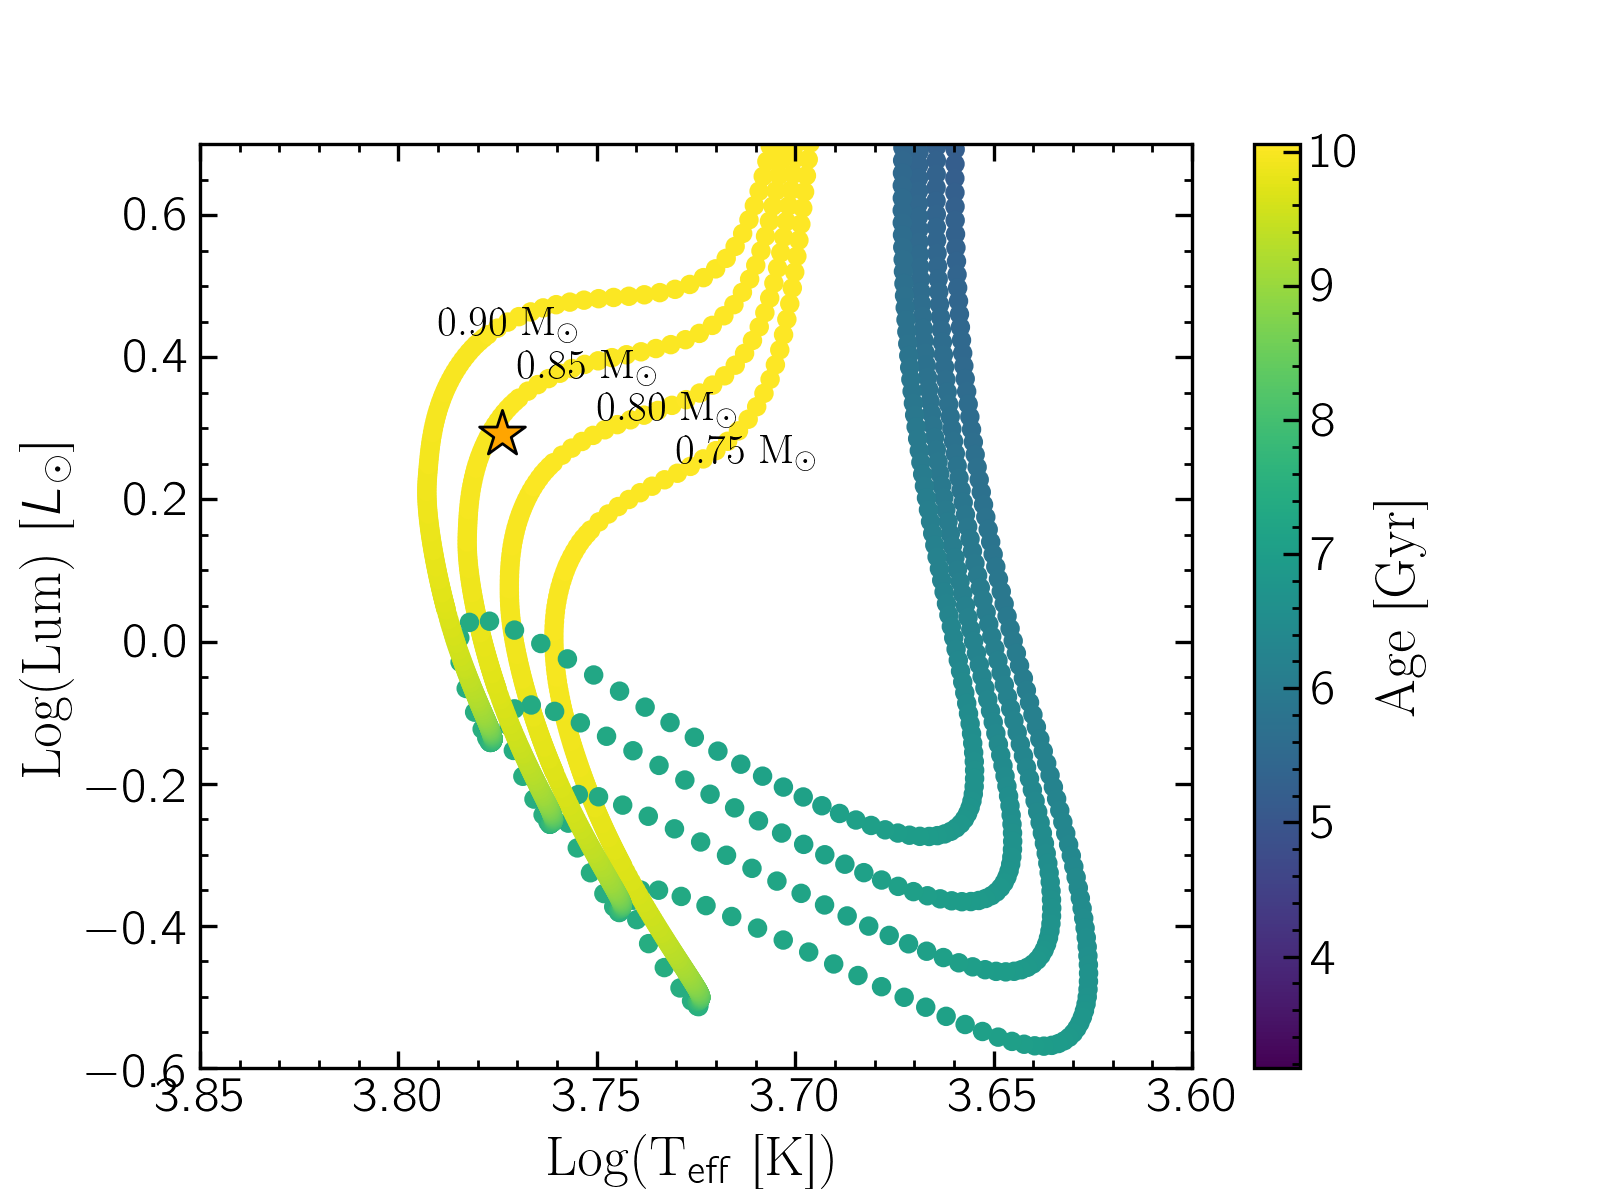

In [218]:
directory = 'MIST_v1.2_feh_m0.50_afe_p0.0_vvcrit0.4_EEPS/'
os.system('ls '+directory+'* > list')
with open('list') as z:
    ff = z.read().splitlines()
Amasses = ['0.75','0.80','0.85','0.90'][::-1]
tracks = []
for f in ff:
    for i in range(len(Amasses)):
        if Amasses[i].replace('0.','000') in f:
            tracks.append(f)
#MistTrack064 = pd.read_table('MIST-evtrack-0006400M-mh-m15.track.eep', delim_whitespace=True, header=11)
A_MistTrack = pd.read_table(tracks[0], delim_whitespace=True, header=11)
columns = A_MistTrack.columns[1:]

x_label_offsets = [0,-0.02,-0.04,-0.06]
y_label_offsets = [0,-0.06,-0.12,-0.18]

%matplotlib notebook
cmap = 'viridis'
for i,track in enumerate(tracks):
    A_MistTrack = pd.read_table(track, delim_whitespace=True, names=columns, comment='#')
    ind = np.where(np.log10(A_MistTrack['star_age']) < 10.5)[0]
    plt.scatter(A_MistTrack['log_Teff'][ind],A_MistTrack['log_L'][ind], 
            c=np.log10(A_MistTrack['star_age'][ind]), cmap=cmap)
    plt.annotate(Amasses[i]+' M$_\odot$',
                 xy=(3.79+x_label_offsets[i], 0.43+y_label_offsets[i]),
                 xycoords = 'data', fontsize=15)
    
cbar = plt.colorbar()
plt.scatter(A_teff_chimin,A_lum_chimin, marker='*', color='orange',s=300, edgecolor='black')


plt.ylim(-0.6,0.7)
plt.xlim(3.60,3.85)
plt.gca().invert_xaxis()
plt.xlabel('Log(T$_\mathrm{eff}$ [K])')
plt.ylabel('Log(Lum) [$L_\odot$]')
cbar.set_label(r'Age [Gyr]')

## C

<IPython.core.display.Javascript object>


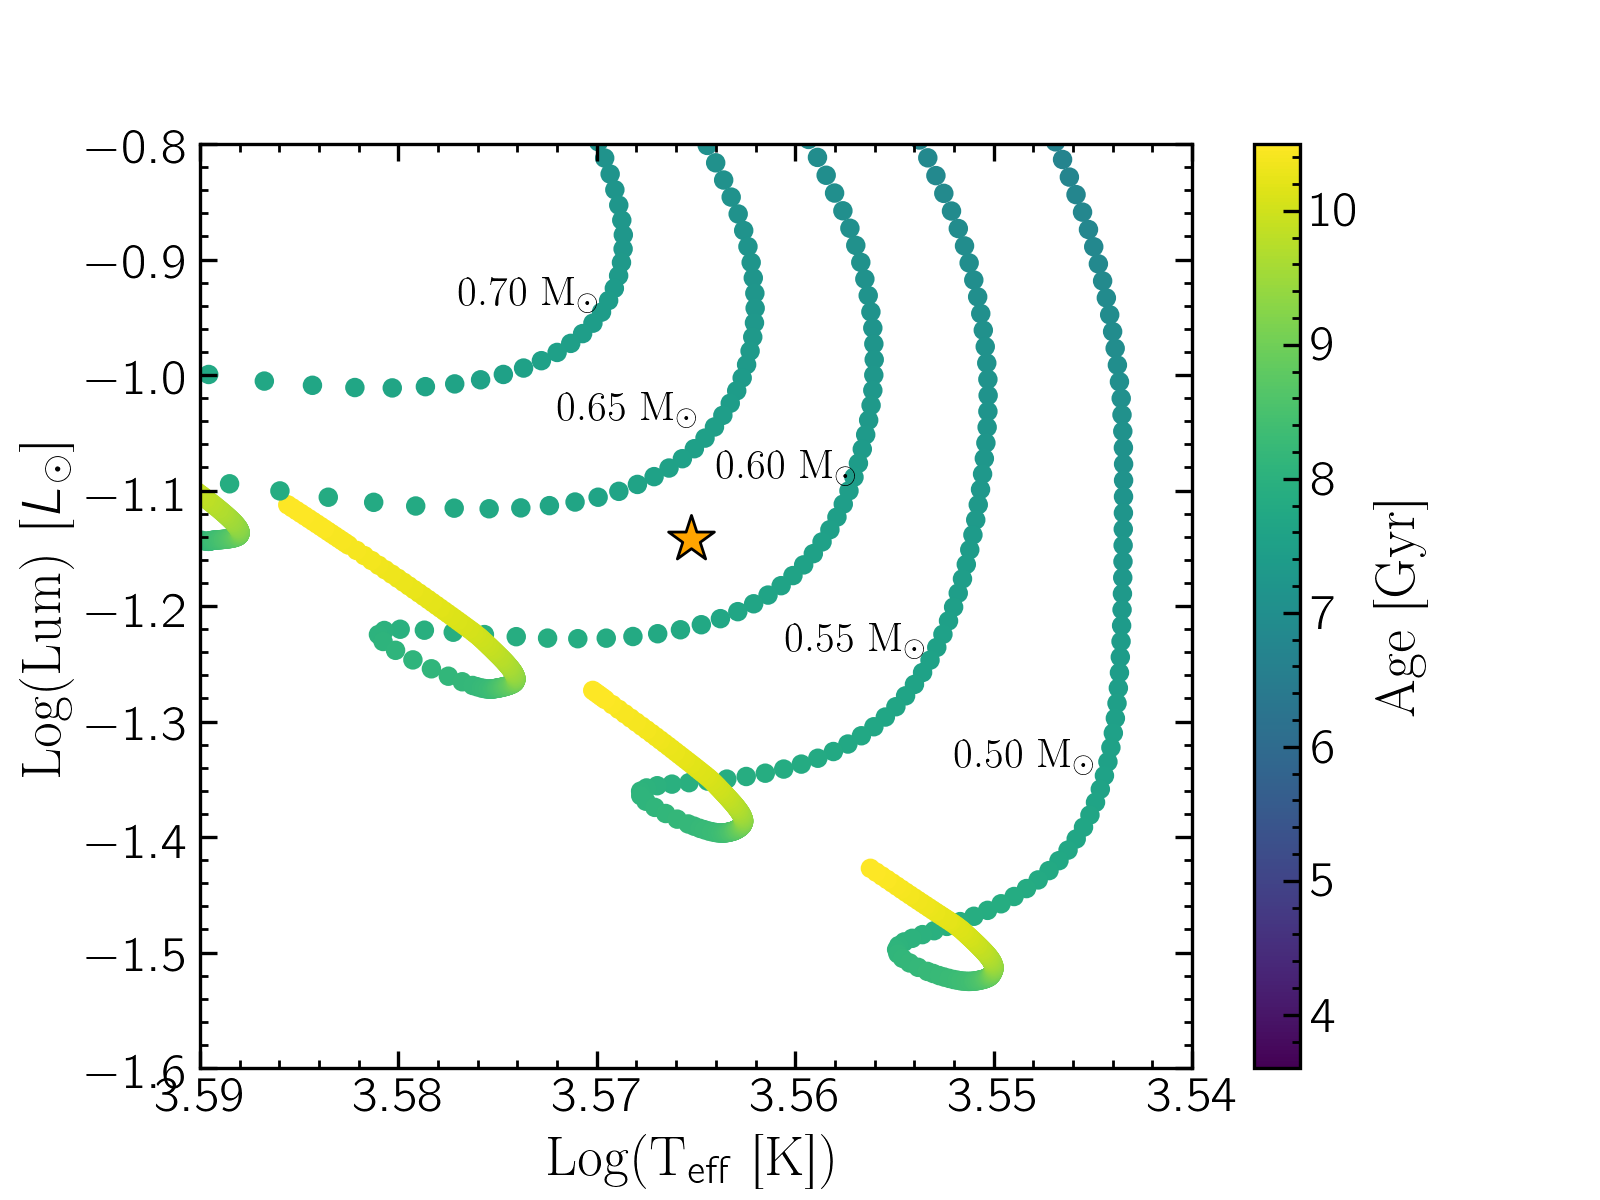

In [244]:
directory = 'MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_EEPS/'
os.system('ls '+directory+'* > list')
with open('list') as z:
    ff = z.read().splitlines()
Cmasses = ['0.50','0.55','0.60','0.65','0.70'][::-1]
tracks = []
for f in ff:
    for i in range(len(Cmasses)):
        if Cmasses[i].replace('0.','000') in f:
            tracks.append(f)
#MistTrack064 = pd.read_table('MIST-evtrack-0006400M-mh-m15.track.eep', delim_whitespace=True, header=11)
C_MistTrack = pd.read_table(tracks[0], delim_whitespace=True, header=11)
columns = C_MistTrack.columns[1:]

x_label_offsets = [0,-0.005,-0.013,-0.0165,-0.025]
y_label_offsets = [0,-0.1,-0.15,-0.3,-0.4]

%matplotlib notebook
cmap = 'viridis'
for i,track in enumerate(tracks):
    C_MistTrack = pd.read_table(track, delim_whitespace=True, names=columns, comment='#')
    ind = np.where(np.log10(C_MistTrack['star_age']) < 10.5)[0]
    plt.scatter(C_MistTrack['log_Teff'][ind],C_MistTrack['log_L'][ind], 
            c=np.log10(C_MistTrack['star_age'][ind]), cmap=cmap)
    plt.annotate(Cmasses[i]+' M$_\odot$',
                 xy=(3.577+x_label_offsets[i], -0.94+y_label_offsets[i]),
                 xycoords = 'data', fontsize=15)
cbar = plt.colorbar()
plt.scatter(C_teff_chimin,C_lum_chimin, marker='*', color='orange',s=300, edgecolor='black')
plt.ylim(-1.6,-0.8)
plt.xlim(3.54,3.59)
plt.gca().invert_xaxis()
plt.xlabel('Log(T$_\mathrm{eff}$ [K])')
plt.ylabel('Log(Lum) [$L_\odot$]')
cbar.set_label(r'Age [Gyr]')

# BUT!  Best fitting ages are different for A & C!

# Constraining the age to be the same:

In [1]:
Amag_SDSS,e_Amag_SDSS,Cmag_SDSS,e_Cmag_SDSS = pickle.load(open('SDSS-magnitudes-noatm.pkl','rb'))

from myastrotools.tools import MonteCarloIt, update_progress

Cmag_SDSS_dict = {'z':Cmag_SDSS[0],'i':Cmag_SDSS[1],'r':Cmag_SDSS[2],'g':Cmag_SDSS[3]}
e_Cmag_SDSS_dict = {'z':e_Cmag_SDSS[0],'i':e_Cmag_SDSS[1],'r':e_Cmag_SDSS[2],'g':e_Cmag_SDSS[3]}

Amag_SDSS_dict = {'z':Amag_SDSS[0],'i':Amag_SDSS[1],'r':Amag_SDSS[2],'g':Amag_SDSS[3]}
e_Amag_SDSS_dict = {'z':e_Amag_SDSS[0],'i':e_Amag_SDSS[1],'r':e_Amag_SDSS[2],'g':e_Amag_SDSS[3]}

CRminusI = MonteCarloIt([Cmag_SDSS_dict['r'],e_Cmag_SDSS_dict['r']]) - \
            MonteCarloIt([Cmag_SDSS_dict['i'],e_Cmag_SDSS_dict['i']])
CGminusR = MonteCarloIt([Cmag_SDSS_dict['g'],e_Cmag_SDSS_dict['g']]) - \
            MonteCarloIt([Cmag_SDSS_dict['r'],e_Cmag_SDSS_dict['r']])

ARminusI = MonteCarloIt([Amag_SDSS_dict['r'],e_Amag_SDSS_dict['r']]) - \
            MonteCarloIt([Amag_SDSS_dict['i'],e_Amag_SDSS_dict['i']])
AGminusR = MonteCarloIt([Amag_SDSS_dict['g'],e_Amag_SDSS_dict['g']]) - \
            MonteCarloIt([Amag_SDSS_dict['r'],e_Amag_SDSS_dict['r']])

Adistance = [220,2]

C_Mr = MonteCarloIt([Cmag_SDSS_dict['r'],e_Cmag_SDSS_dict['r']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
A_Mr = MonteCarloIt([Amag_SDSS_dict['r'],e_Amag_SDSS_dict['r']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
C_Mg = MonteCarloIt([Cmag_SDSS_dict['g'],e_Cmag_SDSS_dict['g']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
A_Mg = MonteCarloIt([Amag_SDSS_dict['g'],e_Amag_SDSS_dict['g']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
C_Mi = MonteCarloIt([Cmag_SDSS_dict['i'],e_Cmag_SDSS_dict['i']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
A_Mi = MonteCarloIt([Amag_SDSS_dict['i'],e_Amag_SDSS_dict['i']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
C_Mz = MonteCarloIt([Cmag_SDSS_dict['z'],e_Cmag_SDSS_dict['z']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5
A_Mz = MonteCarloIt([Amag_SDSS_dict['z'],e_Amag_SDSS_dict['z']]) - 5*np.log10(MonteCarloIt(Adistance)) + 5


CM = [np.mean(C_Mg),np.mean(C_Mr),np.mean(C_Mi),np.mean(C_Mz)]
eCM = [np.std(C_Mg),np.std(C_Mr),np.std(C_Mi),np.std(C_Mz)]
MIST_filter_columnnames = ['SDSS_g','SDSS_r','SDSS_i','SDSS_z']

Ccolorlist = [np.mean(CRminusI),np.mean(CGminusR)]
Cecolorlist = [np.std(CRminusI),np.std(CGminusR)]
MIST_color_columnnames = ['r-i','g-r']

mhs = [-4.00,-3.00,-2.00,-1.50,-1.00,-0.50,-0.25,0.00,0.50]
mhs_strings = []
for i in range(len(mhs)):
    string = str(mhs[i])
    if '-' in string:
        string = string.replace('-','m')
    else:
        string = 'p'+string
    string += '0'
    mhs_strings.append(string)
mhs_strings[6] = mhs_strings[6].replace('m0.250','m0.25')

In [34]:
directory = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/'

i = 0
string = mhs_strings[i]
Cfile = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd--chi2-output-C.csv'
Cmist = pd.read_csv(Cfile)
Afile = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd--chi2-output-A.csv'
Amist = pd.read_csv(Afile)
#np.min(mist['chi2'].loc[np.where(mist['log10_isochrone_age_yr']==5.0)])
ages = np.unique(Cmist['log10_isochrone_age_yr'])


Cmist['vvcrit'] = 0.4
Cmist['feh'] = mhs[i]
Cmist

for i in range(1,len(mhs_strings)):
    string = mhs_strings[i]
    file = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd--chi2-output-C.csv'
    mist = pd.read_csv(file)
    mist['vvcrit'] = 0.4
    mist['feh'] = mhs[i]
    Cmist = pd.concat([Cmist,mist])
    
for i in range(1,len(mhs_strings)):
    string = mhs_strings[i]
    file = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output-C.csv'
    mist = pd.read_csv(file)
    mist['vvcrit'] = 0.0
    mist['feh'] = mhs[i]
    Cmist = pd.concat([Cmist,mist])
    
Amist['vvcrit'] = 0.4
Amist['feh'] = mhs[i]

for i in range(1,len(mhs_strings)):
    string = mhs_strings[i]
    file = 'MIST_v1.2_vvcrit0.4_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd--chi2-output-A.csv'
    mist = pd.read_csv(file)
    mist['vvcrit'] = 0.4
    mist['feh'] = mhs[i]
    Amist = pd.concat([Amist,mist])
    
for i in range(1,len(mhs_strings)):
    string = mhs_strings[i]
    file = 'MIST_v1.2_vvcrit0.0_SDSSugriz-synth-phot/MIST_v1.2_feh_'+string+\
        '_afe_p0.0_vvcrit0.0_SDSSugriz.iso.cmd--chi2-output-A.csv'
    mist = pd.read_csv(file)
    mist['vvcrit'] = 0.0
    mist['feh'] = mhs[i]
    Amist = pd.concat([Amist,mist])
    


EEP  log10_isochrone_age_yr  initial_mass  star_mass  log_Teff  \
0         35                     5.0      0.100000   0.100000  3.617011   
1         36                     5.0      0.102885   0.102885  3.618039   
2         37                     5.0      0.107147   0.107147  3.619556   
3         38                     5.0      0.111379   0.111379  3.621062   
4         39                     5.0      0.115581   0.115581  3.622555   
...      ...                     ...           ...        ...       ...   
105371  1706                    10.3      0.925792   0.532726  4.402490   
105372  1707                    10.3      0.925825   0.532730  4.387132   
105373  1708                    10.3      0.925866   0.532735  4.371789   
105374  1709                    10.3      0.925919   0.532741  4.356480   
105375  1710                    10.3      0.925985   0.532749  4.341226   

           log_g     log_L  [Fe/H]_init    [Fe/H]     SDSS_u     SDSS_g  \
0       3.350571 -0.489734         -4.0 -3.907514   9.179367   7.304730   
1       3.347798 -0.472691         -4.0 -3.907514   9.112976   7.251798   
2       3.343658 -0.447471         -4.0 -3.907514   9.014965   7.173544   
3       3.339612 -0.422498         -4.0 -3.907514   8.918049   7.096093   
4       3.335660 -0.397776         -4.0 -3.907514   8.822323   7.019503   
...          ...       ...          ...       ...        ...        ...   
105371  7.777159 -1.047903          0.5  0.584570   9.590097   9.757511   
105372  7.783242 -1.115415          0.5  0.584574   9.704615   9.845963   
105373  7.789130 -1.182672          0.5  0.584578   9.815765   9.931186   
105374  7.794844 -1.249617          0.5  0.584584   9.924437  10.013835   
105375  7.800376 -1.316157          0.5  0.584591  10.031345  10.094429   

           SDSS_r     SDSS_i     SDSS_z  phase       g-r       r-i  \
0        6.269828   5.822155   5.562423   -1.0  1.034902  0.447673   
1        6.223246   5.778345   5.520555   -1.0  1.028552  0.444901   
2        6.154368   5.713572   5.458643   -1.0  1.019176  0.440796   
3        6.086219   5.649520   5.397408   -1.0  1.009874  0.436699   
4        6.018837   5.586229   5.336873   -1.0  1.000666  0.432608   
...           ...        ...        ...    ...       ...       ...   
105371  10.191074  10.532596  10.866735    6.0 -0.433563 -0.341522   
105372  10.270611  10.607910  10.939060    6.0 -0.424648 -0.337299   
105373  10.346869  10.679877  11.008009    6.0 -0.415683 -0.333008   
105374  10.420485  10.749150  11.074233    6.0 -0.406650 -0.328665   
105375  10.491980  10.816280  11.138297    6.0 -0.397551 -0.324300   

                chi2  vvcrit  feh  
0        7256.775942     0.4 -4.0  
1        7567.267382     0.4 -4.0  
2        8038.589022     0.4 -4.0  
3        8519.140566     0.4 -4.0  
4        9008.191036     0.4 -4.0  
...              ...     ...  ...  
105371  15742.475299     0.0  0.5  
105372  16462.294635     0.0  0.5  
105373  17167.534989     0.0  0.5  
105374  17862.480396     0.0  0.5  
105375  18551.139304     0.0  0.5  

[1726671 rows x 20 columns]

In [41]:
Cmist = Cmist.reset_index(drop = True)
Amist = Amist.reset_index(drop = True)
Cmist.loc[np.where(Cmist['chi2'] == np.min(Cmist['chi2']))[0][0]]

EEP                       179.000000
log10_isochrone_age_yr      7.650000
initial_mass                0.626874
star_mass                   0.626873
log_Teff                    3.565235
log_g                       4.592193
log_L                      -1.141626
[Fe/H]_init                 0.500000
[Fe/H]                      0.590761
SDSS_u                     12.503833
SDSS_g                     10.155502
SDSS_r                      8.940088
SDSS_i                      7.852459
SDSS_z                      7.236546
phase                      -1.000000
g-r                         1.215414
r-i                         1.087629
chi2                       19.737478
vvcrit                      0.400000
feh                         0.500000
Name: 824472, dtype: float64

In [43]:
Cmist.to_csv('MIST_models_master-C.csv', index=False)

In [57]:
Amist.to_csv('MIST_models_master-A.csv', index=False)

## Find lowest chi2 models:

In [1]:
import pandas as pd
Amist = pd.read_csv('MIST_models_master-A.csv')
Cmist = pd.read_csv('MIST_models_master-C.csv')
ages = np.unique(Cmist['log10_isochrone_age_yr'])


In [ ]:
age = ages[0]
Aind = np.where(Amist['log10_isochrone_age_yr'] == age)[0]
Cind = np.where(Cmist['log10_isochrone_age_yr'] == age)[0]
Cmist_temp = Cmist.loc[Cind]
Cmist_temp = Cmist_temp.reset_index()
Amist_temp = Amist.loc[Aind]
Amist_temp = Amist_temp.reset_index()

Carray = np.array(Cmist_temp['chi2'])
Aarray = np.array(Amist_temp['chi2'])

In [ ]:
# for each age:
for i,age in enumerate(ages[1:]):
    # pull out relevant indicies:
    Aind = np.where(Amist['log10_isochrone_age_yr'] == age)[0]
    Cind = np.where(Cmist['log10_isochrone_age_yr'] == age)[0]
    Cmist_temp = Cmist.loc[Cind]
    Cmist_temp = Cmist_temp.reset_index()
    Amist_temp = Amist.loc[Aind]
    Amist_temp = Amist_temp.reset_index()
    # get the chi2:
    Carray = np.array(Cmist_temp['chi2'])
    Aarray = np.array(Amist_temp['chi2'])
    # sum the chi2 of each star:
    summedchi = Aarray[np.newaxis,:] + Carray[:,np.newaxis]
    # write out results:
    np.save('/Volumes/En/HIP67506/MIST/chi2-matrix-constrainedage-'+str(np.round(age,decimals=2)),summedchi)
    update_progress(i,len(ages[1:]))